In [1]:
!pip install datasets
!pip install transformers
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 618.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.1 MB/s eta 0:00

### 준비

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'deeplearning/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

MessageError: ignored

In [ ]:
from datasets import load_dataset

# Load all helpfulness/harmless subsets (share the same schema)
train_dataset = load_dataset("Anthropic/hh-rlhf", split="train")
test_dataset= load_dataset("Anthropic/hh-rlhf", split="test")

# dialogue_dataset = load_dataset("daily_dialog")

In [ ]:
import pandas as pd
import re
from itertools import combinations
import io
import json
import os
import ast

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.categorical import Categorical
from tqdm import tqdm

import transformers
from transformers import GPTNeoForCausalLM, GPT2Tokenizer, AdamW, get_scheduler, GPTNeoModel, GPT2LMHeadModel
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from typing import List, Deque
from einops import rearrange
import datetime

import logging
logging.getLogger().setLevel(logging.CRITICAL)

import warnings
warnings.filterwarnings('ignore')

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

models_folder = "trained_models" # where to save model

In [ ]:
model = GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M")
tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-125M', bos_token='<|startoftext|>', eos_token='<|endoftext|>')
tokenizer.pad_token = tokenizer.eos_token

model.to(device)
print('skip')

### Supervised Fune tuning

In [ ]:
# wte = model.transformer.wte
# wpe = model.transformer.wpe
# drop = model.transformer.drop
# h = model.transformer.h
# attention_layers = h
# # layer=attention_layers[0] # 11 layers = 125M
# # model.transformer.h = nn.ModuleList([layer])
# # model.train()

In [ ]:
# get fine-tuned model?

model_path = GOOGLE_DRIVE_PATH + models_folder + f"/gptneo_dialog22.pt"
model.load_state_dict(torch.load(model_path)) # 여기서는 dict만 불러온다. 애초에 dict만 저장함.

In [ ]:
class QaDataset(torch.utils.data.Dataset):
  def __init__(self):
    super().__init__()

    self.data_list = []
    self.end_of_text_token = "<|endoftext|>"
    
    x = 0
    for td in train_dataset:
      text = td['chosen'].strip('\n\n')
      conv = text.split("Human:")
      history=""
      for conversation in conv[1:]:
        conversation = history+"Human:"+conversation
        history = conversation[:]
        if len(conversation)<450 and len(conversation)>10:
          # only one conversation
          data_str = f"{conversation}{self.end_of_text_token}"
          self.data_list.append(data_str)

  def __len__(self):
      return len(self.data_list)

  def __getitem__(self, index):
      text = self.data_list[index]
      inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=400, padding="max_length") #pad => special token X

      return inputs, text # text is not used during training, it's just for check

In [ ]:
class BookDataset(torch.utils.data.Dataset):
  def __init__(self, books):
    super(BookDataset, self).__init__()
    self.data_list=[]
    books = ["harry1.txt", "harry2.txt", "harry3.txt"]
    for book in books:
      book_path = "deepdai/"+book
      with open(GOOGLE_DRIVE_PATH+book_path, "r") as f:
        lines=f.readlines()
      lines = [x.replace("\n", "").strip() for x in lines if "J.K. Rowling" not in x and len(x)>1]
      prev=""
      fixed_lines=[]
      for l in lines:
        prev += " " + l
      prev = prev.split(".")
      his=""
      for i, p in enumerate(prev):
        if p[-2:]=="Mr" or p[-3:]=="Mrs":
          his+=p
        else:
          if len(his)>1:
            his += "."
          fixed_lines.append((his+p+".").strip())
          his=""
      rec = ""
      for f in fixed_lines:
        if len(rec+f)<400:
          rec += f
        else:
          self.data_list.append(rec)
          rec=""
  
  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    text=self.data_list[idx]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=300, padding="max_length") #pad => special token X

    return inputs, text # text is not used during training, it's just for check

In [ ]:
# Daily Dialogue Dataset
class DialogueDataset(torch.utils.data.Dataset):
  def __init__(self):
    super(DialogueDataset, self).__init__()

    self.data_list=[]
    self.end_of_text_token = "<|endoftext|>"
    
    for td in dialogue_dataset['train']:
      history=""
      for i in range(int(len(td['dialog'])/2)):
        if len(history) > 3:
          history += '\n\n'
        conv = history+"Human:"+td['dialog'][i*2]+"\n\nAssistant: "+td['dialog'][i*2+1]
        history = conv[:]
        if len(conv)<450 and len(conv)>10:
          # only one conversation
          self.data_list.append(f"{conv}{self.end_of_text_token}")
  
  def __len__(self):
    return len(self.data_list)
  
  def __getitem__(self, idx):
    text=self.data_list[idx]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=600, padding="max_length") #pad => special token X

    return inputs, text # text is not used during training, it's just for check

In [ ]:
class EvidenceLoader(torch.utils.data.Dataset):
  def __init__(self):
    super(EvidenceLoader, self).__init__()
    self.data_list = []
    self.eos_token = "<|endoftext|>"

    loaded = load_dataset("squad_v2")
    train_data = loaded['train']
    for d in train_data:
      if len(d['answers']['text']) > 0:
        prompt = f"Human:{d['question']}\n\nBase:{d['context']}\n\nAssistant:{d['answers']['text'][0]}{self.eos_token}"
        self.data_list.append(prompt)
  
  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    text=self.data_list[idx]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=600, padding="max_length") #pad => special token X

    return inputs, text

In [ ]:
class InstructLoader(torch.utils.data.Dataset):
  def __init__(self):
    super(InstructLoader, self).__init__()
    self.data_list = []
    self.eos_token = "<|endoftext|>"

    loaded = load_dataset("nlpcloud/instructions-dataset-adapted-from-stanford-alpaca-for-gpt-j")
    train_data = loaded['train']

    temp=[]
    for d in train_data:
      text=d['text']
      if text!=self.eos_token:
        temp.append(text)
      else:
        summed_text=""
        if len(temp)==3:
          summed_text+=f"Human:{temp[0]}\n\n{temp[1]}\n\nAssistant:{temp[2]}{self.eos_token}"
          if len(summed_text)<500:
            self.data_list.append(summed_text)
        elif len(temp)==2:
          summed_text+=f"Human:{temp[0]}\n\nAssistant:{temp[1]}{self.eos_token}"
          if len(summed_text)<500:
            self.data_list.append(summed_text)
        temp=[]
  
  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, idx):
    text=self.data_list[idx]
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=600, padding="max_length") #pad => special token X

    return inputs, text

In [ ]:
# Anthropic, QA dataset
dataset = QaDataset()
qa_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

NameError: ignored

In [ ]:
# Harry potter book, domain knowledge dataset
bd = BookDataset(["harry1.txt", "harry2.txt", "harry3.txt"])
book_loader = torch.utils.data.DataLoader(bd, batch_size=BATCH_SIZE, shuffle=True)

NameError: ignored

In [ ]:
dd = DialogueDataset()
dialog_loader = torch.utils.data.DataLoader(dd, batch_size=BATCH_SIZE, shuffle=True)

NameError: ignored

In [ ]:
ed = EvidenceLoader()
ed_loader = torch.utils.data.DataLoader(ed, batch_size=4, shuffle=True)

In [ ]:
idd = InstructLoader()
id_loader = torch.utils.data.DataLoader(idd, batch_size=4, shuffle=True)

In [ ]:
# default value settings
BATCH_SIZE = 4
EPOCHS = 5
# LEARNING_RATE = 0.00001
LEARNING_RATE = 0.00001
WARMUP_STEPS = 0
MAX_SEQ_LEN = 1500

In [ ]:
from transformers import AdamW

# num of training steps = epoch * lengh of data
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE,  betas=(0.9, 0.95))
proc_seq_count = 0
sum_loss = 0.0
batch_count = 0

num_training_steps = EPOCHS*len(id_loader)

In [ ]:
# scheduler
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=num_training_steps,
)

In [ ]:
model.train()

print("skip")

skip


In [ ]:
for epoch in range(0, 5):
  batch_count = 0
  print(f"EPOCH {epoch} started" + '=' * 30)

  for idx, (data, text) in tqdm(enumerate(id_loader)):
    # this data is returned from tokenizer => three types.
    input_ids, attention_mask = data['input_ids'].to(device), data['attention_mask'].to(device)
    print(text)

    #forward process
    outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)

    # what is loss and logits?
    loss, logits = outputs.loss, outputs.logits
    loss.backward()

    sum_loss = sum_loss + loss.detach().data

    # update optimizer for weight, scheduler for learning_rate
    optimizer.step()
    scheduler.step()

    # reset grads to 0 before another training
    optimizer.zero_grad()
    model.zero_grad()

    batch_count += 1
    if batch_count == 100:
        print(f"sum loss {sum_loss}")
        batch_count = 0
        sum_loss = 0.0

        prompt = "Who is Harry potter?"
        response, tokens = inference(prompt)
        print(response)

  # Store the model after each epoch to compare the performance of them
  torch.save(model.state_dict(), GOOGLE_DRIVE_PATH + models_folder + f"/gptneo_{datetime.datetime.today().month}_{datetime.datetime.today().day}_inst_{epoch}.pt")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.save(model.state_dict(), GOOGLE_DRIVE_PATH + models_folder + f"/gptneo_dialog22.pt") # 모델의 파라미터만 저장

### 모델 불러와서 Inference

In [ ]:
model_path = GOOGLE_DRIVE_PATH + models_folder + f"/gptneo_dialog22.pt"
model.load_state_dict(torch.load(model_path)) # 여기서는 dict만 불러온다. 애초에 dict만 저장함.

model.eval()
print("skip")

skip


scores (optional): the prediction scores of the language modelling head, for each generation step

In [ ]:
def inference(prompt):
  prompt = "Human: "+prompt+"\n\nAssistant: "
  tokenized = tokenizer(prompt, return_tensors="pt").to(device)

  input_ids, attention_mask = tokenized['input_ids'].to(device), tokenized['attention_mask'].to(device)

  generated = model.generate(
      input_ids,
      do_sample=True,
      attention_mask=attention_mask,
      max_length=400,
      # output_scores=True,
      return_dict_in_generate=True,
      top_k=2
      # temperature=0.3,
  )

  return tokenizer.decode(generated.sequences[0]), generated.sequences[0]

In [ ]:
prompt = "What are you talking about?"

response, tokens = inference(prompt)
print(response)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Human: What are you talking about?

Assistant:  I’m not sure what you’re asking me.  Can you tell me more about the question?

Human: I want to know what you mean by “what are you talking about”.

Assistant:  I’m not sure what you mean by “what are you talking about.”  Can you tell me more about the question?<|endoftext|>


## Reward Model training

In [ ]:
import copy 

class RmDataset(torch.utils.data.Dataset):
  def __init__(self):
    super().__init__()

    self.chosen_list = []
    self.rejected_list = []
    self.end_of_text_token = "<|endoftext|>"
    
    x = 0
    train_dataset_copy = copy.deepcopy(train_dataset)
    for td in train_dataset_copy:
      # rtext1 = "Human:" + td['chosen'].split("Human:")[-1]
      # rtext2 = "Human:" + td['rejected'].split("Human:")[-1]

      # if len(text1)<500 and len(text2)<500:
      #   self.chosen_list.append(f"{text1}{self.end_of_text_token}")
      #   self.rejected_list.append(f"{text2}{self.end_of_text_token}")

      # only response
      rtext1 = td['chosen'].split("Assistant:")[-1]
      rtext2 = td['rejected'].split("Assistant:")[-1]
      if len(rtext1)<700 and len(rtext2)<700 and rtext1 != rtext2 and len(rtext1)>4 and len(rtext2)>4:
        self.chosen_list.append(f"{rtext1}{self.end_of_text_token}")
        self.rejected_list.append(f"{rtext2}{self.end_of_text_token}")

  def __len__(self):
    return len(self.chosen_list)

  def __getitem__(self, index):
    chosen_text = self.chosen_list[index]
    rejected_text = self.rejected_list[index]

    return chosen_text, rejected_text

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

class BaseBertRewardModel(nn.Module):
  def __init__(self):
    super(BaseBertRewardModel, self).__init__()

    # Load tokenizer and model
    self.base = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).to(device)
    self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    self.tokenizer.pad_token = "<|endoftext|>"
  
  def forward(self, prompts):
    tokenized=self.tokenizer(prompts, padding=True, truncation=True, return_tensors='pt')
    input_ids, attention_masks=tokenized['input_ids'].to(device), tokenized['attention_mask'].to(device)

    outputs = self.base(input_ids, attention_mask=attention_masks)

    return outputs.logits.squeeze()

In [ ]:
from transformers import RobertaForSequenceClassification, AutoTokenizer

class BertRewardModel(nn.Module):
  def __init__(self):
    super(BertRewardModel, self).__init__()

    # Load tokenizer and model
    # self.base = RobertaForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1).to(device)
    self.base = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion").to(device)
    self.tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
    self.tokenizer.pad_token = "<|endoftext|>"
    self.last_layer=nn.Linear(4,1).to(device)
  
  def forward(self, prompts):
    tokenized=self.tokenizer(prompts, padding=True, truncation=True, return_tensors='pt')
    input_ids, attention_masks=tokenized['input_ids'].to(device), tokenized['attention_mask'].to(device)

    outputs = self.base(input_ids, attention_mask=attention_masks)
    outputs = self.last_layer(outputs.logits)

    return outputs

In [ ]:
bert_reward_model = BaseBertRewardModel()

KeyboardInterrupt: ignored

In [ ]:
#bert tuning한 모델 불러오기
model_path = GOOGLE_DRIVE_PATH + models_folder + f"/bert_reward_1.pt"
bert_reward_model.load_state_dict(torch.load(model_path)) # 여기서는 dict만 불러온다. 애초에 dict만 저장함.
bert_reward_model.to(device)

print("skip")

skip


In [ ]:
setting = {
    "num_epochs":3,
    "batch_size":2,
    "lr":0.000003,
    "reg":1e-5,
}

reward_dataset = RmDataset()
dataset_size = len(reward_dataset)

train_size = int(dataset_size * 0.9)
validation_size = dataset_size - train_size
# test_size = dataset_size - train_size - validation_size

reward_train_dataset, reward_validation_dataset = torch.utils.data.random_split(reward_dataset, [train_size, validation_size])

splited_data = {"train_data":reward_train_dataset, "val_data":reward_validation_dataset}

### 생략

In [ ]:
class GPTNeoRewardModel(nn.Module):
  def __init__(self):
    super(GPTNeoRewardModel, self).__init__()
    self.base = GPTNeoModel.from_pretrained("EleutherAI/gpt-neo-125M").to(device)
    self.tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-125M', bos_token='<|startoftext|>', eos_token='<|endoftext|>')
    # self.tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-125M', bos_token='<|startoftext|>', eos_token='<|endoftext|>', padding_side="left")
    self.tokenizer.pad_token = '<|endoftext|>'
    self.reward_layer = nn.Linear(768, 1).to(device)
  
  def forward(self, prompts):
    # prompts include both state and action could be raw text of tensor
    tokenized=self.tokenizer(prompts, return_tensors='pt', max_length=1500, padding=True)
    input_ids, attention_mask = tokenized.input_ids.to(device), tokenized.attention_mask.to(device)
    last_hidden_states=self.base(input_ids, attention_mask=attention_mask).last_hidden_state
    
    # use final hidden state's EOS embedding token for classification
    eos_hidden_states=last_hidden_states[:,-1,:]
    rewards=self.reward_layer(eos_hidden_states)
    return rewards, eos_hidden_states

In [ ]:
class RMTrainer():
  def __init__(self, data):
    self.train_data=data['train_data']
    self.val_data=data['val_data']
    self.sigmoid = nn.Sigmoid()
    self.train_logs={
        "loss_history":[],
        "acc_history":[],
        "val_acc_history":[],
    }
    self.reward_model = GPTNeoRewardModel()
    self.bert_reward_model = BertRewardModel()

  def plot_logs(self, idx, lr, reg, batch_size):
    save_text = f"index : {idx}, learning_rate : {lr}, reg : {reg}, batch_size : {batch_size}"
    # Open a file for writing
    with open(GOOGLE_DRIVE_PATH + 'reward_logs.txt', 'a') as f:
      # Write content to the file
      f.write(save_text)

    loss_history=self.train_logs['loss_history']
    acc_history=self.train_logs['acc_history']
    plt.figure(figsize=(15,5))
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(loss_history, "b-")
    plt.show()

    plt.figure(figsize=(15,5))
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.plot(acc_history, "r-")
    plt.show()

  def get_loss(self, chosens, rejecteds):
    # 전부 다 배치로 처리된다는 점을 고려해야한다.
    batch_size = len(rejecteds)
    correct_count=0
    
    chosen_rewards, eos = self.reward_model(chosens) # should be +
    rejecteds_rewards, eos = self.reward_model(rejecteds) # should be -

    loss = torch.FloatTensor([0]).to(device)

    for idx, rejec_reward in enumerate(rejecteds_rewards):
      chosen_reward = chosen_rewards[idx]
      diff = chosen_reward - rejec_reward # this should be +1,    -1 is the worst
      loss = loss-torch.log(self.sigmoid(diff))
      correct_count+=(chosen_reward.item()>rejec_reward.item()) # for count

    loss = loss/len(rejecteds_rewards)
    accuracy = correct_count/len(rejecteds_rewards)
    return loss, accuracy

  def validate(self):
    self.reward_model.eval()
    valid_loader=torch.utils.data.DataLoader(self.val_data, batch_size=32, shuffle=True)
    avg_val_acc=0

    for iter in range(10):
      val_acc=0
      for idx, val_data in enumerate(valid_loader):
        chosen, rejected=val_data
        rejected_list=[]
        chosen_idx_list=[]
        correct_count=0

        chosen_rewards, eos=self.reward_model(chosens)
        rejected_rewards, eos=self.reward_model(rejected_list)

        for rej_idx, rejected_reward in enumerate(rejected_rewards):
          chosen_reward=chosen_rewards[rej_idx]
          correct_count+=(chosen_reward>rejected_reward)
        acc=correct_count/len(rejected_list)
        val_acc=(val_acc*idx+acc)/(idx+1)
      avg_val_acc=avg_val_acc+(val_acc-avg_val_acc)/(iter+1)
    return avg_val_acc

    return 0

  def train(self, num_epochs, batch_size, lr, reg):
    train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
    rm_optimizer = optim.AdamW(self.reward_model.parameters(), lr=lr, weight_decay=reg)
    
    for epoch in range(num_epochs):
      train_acc = 0
      for idx, data in tqdm(enumerate(train_loader)):
        self.reward_model.train() # train 상태로 둔다.
        chosens, rejecteds = data
        loss, acc = self.get_loss(chosens, rejecteds)

        # weight update
        rm_optimizer.zero_grad()
        loss.backward()
        rm_optimizer.step()

        # tran_acc update
        train_acc = (train_acc*idx + acc)/(idx+1)
        self.train_logs['loss_history'].append(loss.item())
        self.train_logs['acc_history'].append(train_acc)

        if idx%200 == 0:
          self.plot_logs(idx, lr, reg, batch_size)
          print(f"Loss: {np.mean(self.train_logs['loss_history'])}, all_acc : {train_acc}")
      val_acc=self.validate()
      print("validation accuracy : ", val_acc)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

class DeBertRewardModel(nn.Module):
  def __init__(self):
    super(DeBertRewardModel, self).__init__()

    # Load tokenizer and model  
    self.tokenizer = AutoTokenizer.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2")
    self.base = AutoModelForSequenceClassification.from_pretrained("OpenAssistant/reward-model-deberta-v3-large-v2").to(device)
    self.tokenizer.pad_token = "<|endoftext|>"
  
  def forward(self, prompts):
    tokenized=self.tokenizer(prompts, padding=True, truncation=True, return_tensors='pt')
    input_ids, attention_masks=tokenized['input_ids'].to(device), tokenized['attention_mask'].to(device)

    outputs = self.base(input_ids, attention_mask=attention_masks)

    return outputs.logits.squeeze()

In [ ]:
debert_model=DeBertRewardModel()

In [ ]:
debert_model.to(device)

print("skip")

skip


### 진행

In [ ]:
class BertRMTrainer():
  def __init__(self, data):
    self.train_data=data['train_data']
    self.val_data=data['val_data']
    self.sigmoid = nn.Sigmoid()
    self.train_logs={
        "loss_history":[],
        "acc_history":[],
        "val_acc_history":[],
    }
    # self.bert_reward_model = bert_reward_model
    self.bert_reward_model = debert_model

  def plot_logs(self, idx, lr, reg, batch_size):
    save_text = f"accuracy : {self.train_logs['acc_history'][-1]}, loss : {self.train_logs['loss_history'][-1]}, index : {idx}, learning_rate : {lr}, reg : {reg}, batch_size : {batch_size} \n\n"
    # Open a file for writing
    with open(GOOGLE_DRIVE_PATH + 'reward_logs3.txt', 'a') as f:
      # Write content to the file
      f.write(save_text)

    loss_history=self.train_logs['loss_history']
    acc_history=self.train_logs['acc_history']
    plt.figure(figsize=(15,5))
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.plot(loss_history, "b-")
    plt.show()

    plt.figure(figsize=(15,5))
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.plot(acc_history, "r-")
    plt.show()

  def get_loss(self, chosens, rejecteds):
    # 전부 다 배치로 처리된다는 점을 고려해야한다.
    batch_size = len(rejecteds)
    correct_count=0
    
    chosen_rewards = self.bert_reward_model(chosens) # should be +
    rejecteds_rewards = self.bert_reward_model(rejecteds) # should be -

    loss = torch.FloatTensor([0]).to(device)

    diff = chosen_rewards - rejecteds_rewards # this should be +1,    -1 is the worst
    loss = loss-torch.log(self.sigmoid(torch.sum(diff)))

    # count = torch.sum(chosen_rewards.logits.squeeze() > rejecteds_rewards.logits.squeeze())
    count = torch.sum(chosen_rewards > rejecteds_rewards)
    correct_count+=count.item() # for count

    loss = loss/len(rejecteds_rewards)
    accuracy = correct_count/len(rejecteds_rewards)
    return loss, accuracy
  
  def get_acc(self, chosens, rejecteds):
    # 전부 다 배치로 처리된다는 점을 고려해야한다.
    correct_count=0
    chosen_rewards = self.bert_reward_model(chosens) # should be +
    rejecteds_rewards = self.bert_reward_model(rejecteds) # should be -

    count = torch.sum(chosen_rewards > rejecteds_rewards)
    correct_count+=count.item() # for count

    accuracy = correct_count/4
    return accuracy


  def valid(self, num_epochs, batch_size, lr, reg):
    self.bert_reward_model.eval()
    valid_loader=torch.utils.data.DataLoader(self.val_data, batch_size=4, shuffle=True)

    for epoch in range(num_epochs):
      train_acc = 0
      for idx, data in tqdm(enumerate(valid_loader)):
        self.bert_reward_model.train() # train 상태로 둔다.

        chosens, rejecteds = data
        # acc = self.get_acc(chosens, rejecteds)
        acc = self.get_acc(chosens, rejecteds)

        # tran_acc update
        train_acc = (train_acc*idx + acc)/(idx+1)
        self.train_logs['loss_history'].append(0)
        self.train_logs['acc_history'].append(train_acc)

        if idx%100 == 0:
          self.plot_logs(idx, lr, reg, batch_size)
          print(f"Loss: {np.mean(self.train_logs['loss_history'])}, all_acc : {train_acc}")

  def train(self, num_epochs, batch_size, lr, reg):
    train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
    rm_optimizer = optim.AdamW(self.bert_reward_model.parameters(), lr=lr, weight_decay=reg)
    
    for epoch in range(num_epochs):
      train_acc = 0
      for idx, data in tqdm(enumerate(train_loader)):
        self.bert_reward_model.train() # train 상태로 둔다.

        chosens, rejecteds = data
        loss, acc = self.get_loss(chosens, rejecteds)

        # weight update
        rm_optimizer.zero_grad()
        loss.backward()
        rm_optimizer.step()

        # tran_acc update
        train_acc = (train_acc*idx + acc)/(idx+1)
        self.train_logs['loss_history'].append(loss.item())
        self.train_logs['acc_history'].append(train_acc)

        if idx%100 == 0:
          self.plot_logs(idx, lr, reg, batch_size)
          print(f"Loss: {np.mean(self.train_logs['loss_history'])}, all_acc : {train_acc}")
        if idx%2000 == 0:
          torch.save(self.bert_reward_model.state_dict(), GOOGLE_DRIVE_PATH + models_folder + f"/bert_reward_{epoch+10}.pt")          

In [ ]:
bert_re = BertRMTrainer(splited_data)

0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


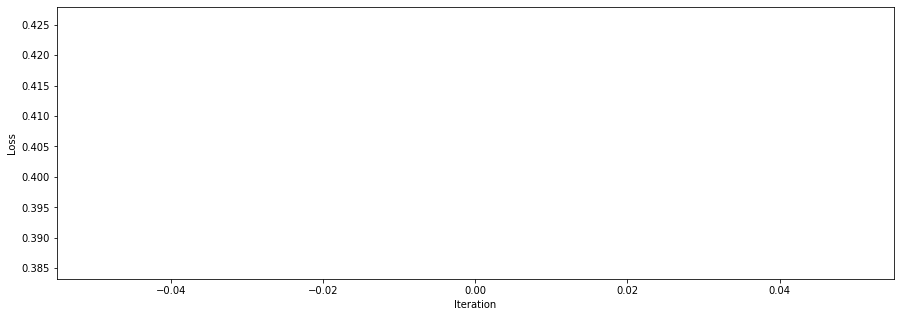

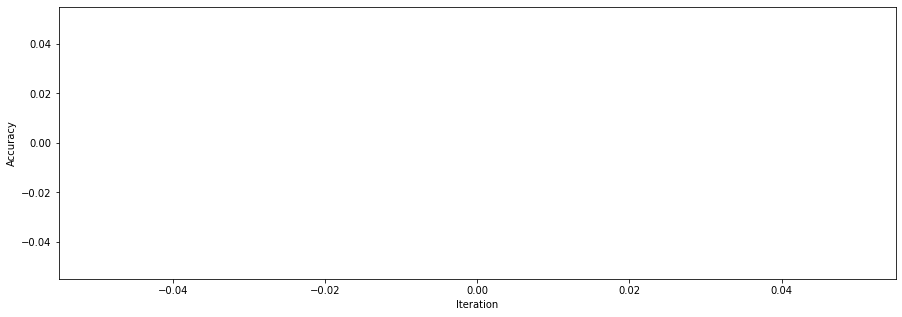

Loss: 0.4055830240249634, all_acc : 0.0


100it [01:19,  1.68it/s]

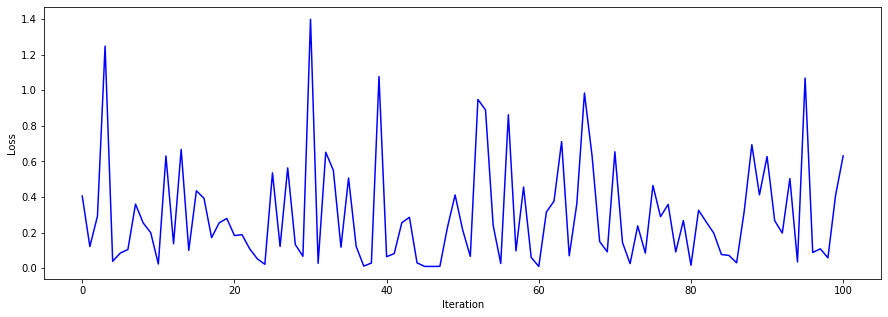

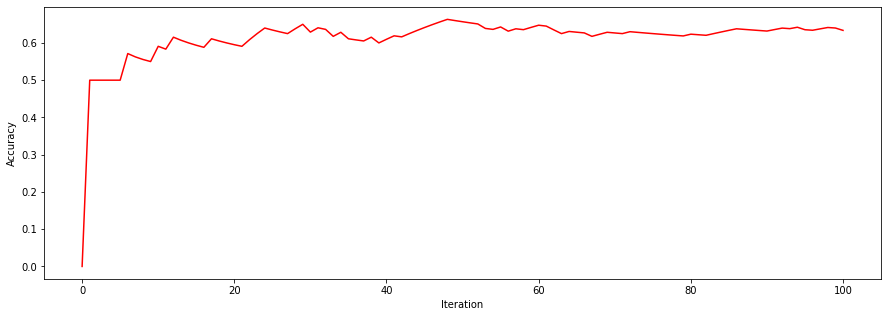

101it [01:20,  1.48it/s]

Loss: 0.30347316146892783, all_acc : 0.6336633663366339


200it [02:20,  1.79it/s]

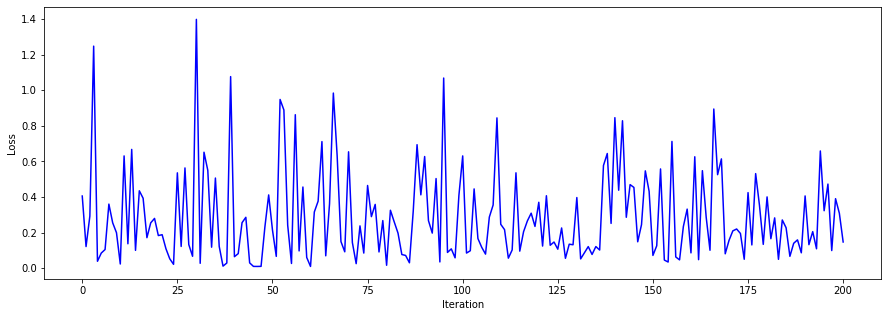

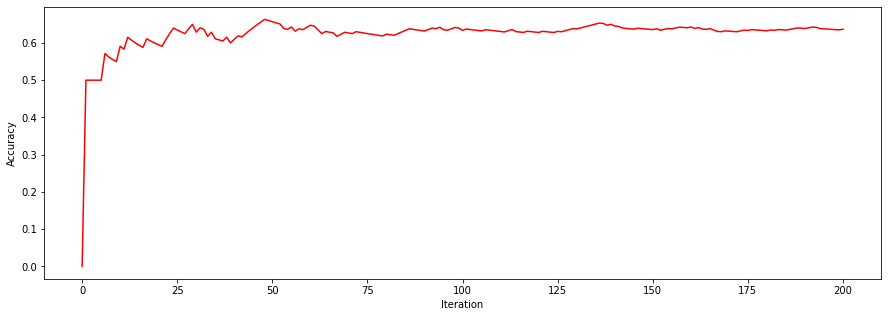

201it [02:21,  1.41it/s]

Loss: 0.2880762360610105, all_acc : 0.6368159203980105


300it [03:20,  1.52it/s]

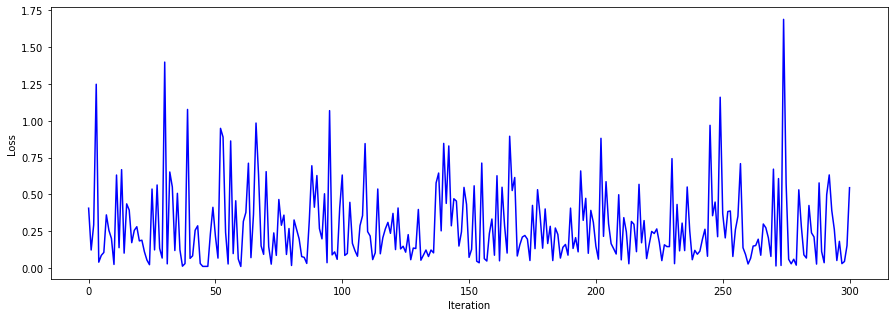

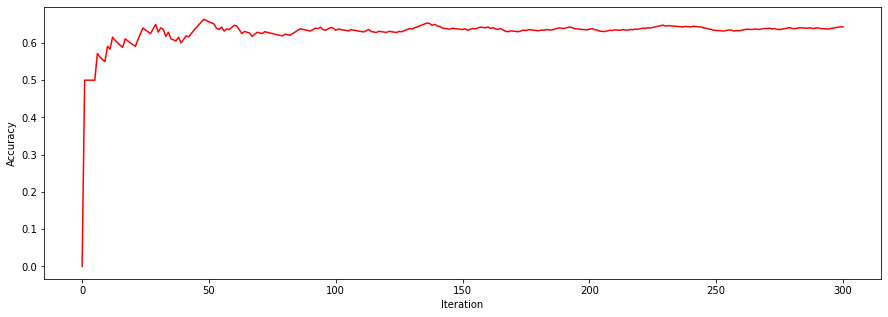

301it [03:21,  1.39it/s]

Loss: 0.28279121411945735, all_acc : 0.6428571428571432


400it [04:19,  1.60it/s]

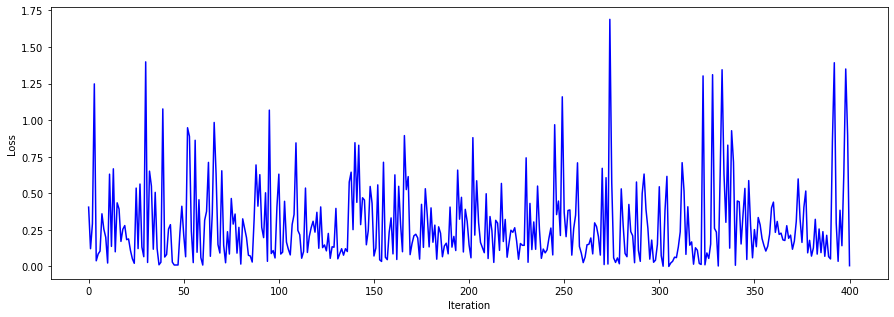

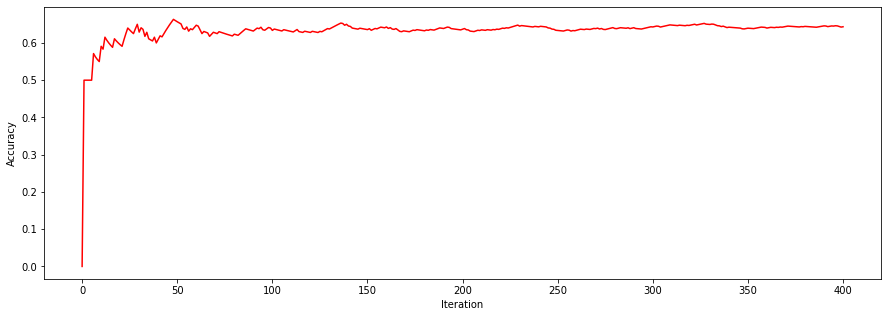

401it [04:20,  1.35it/s]

Loss: 0.28942438345120874, all_acc : 0.643391521197008


500it [05:19,  1.81it/s]

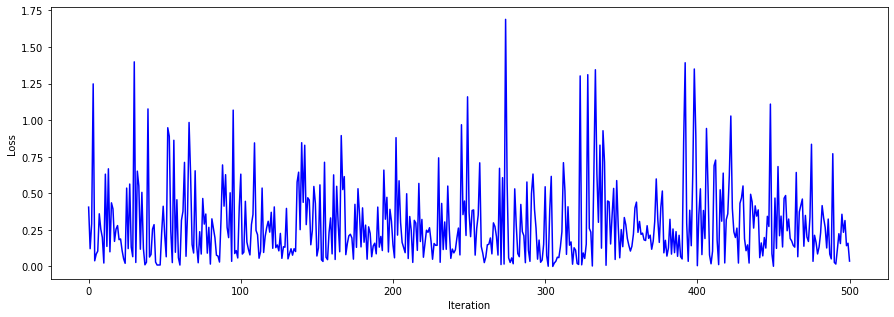

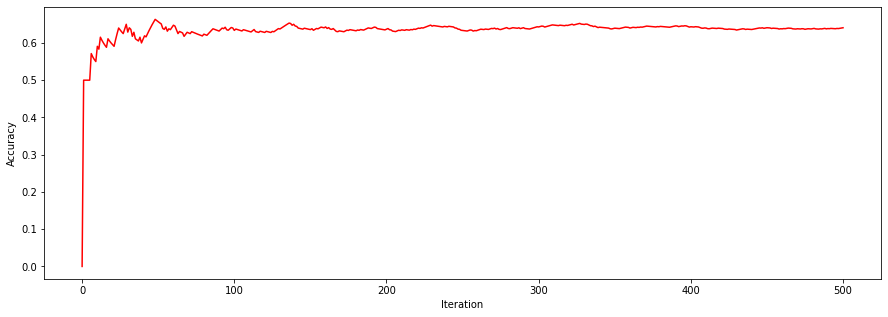

501it [05:20,  1.47it/s]

Loss: 0.29076414648733917, all_acc : 0.640718562874252


600it [06:17,  1.71it/s]

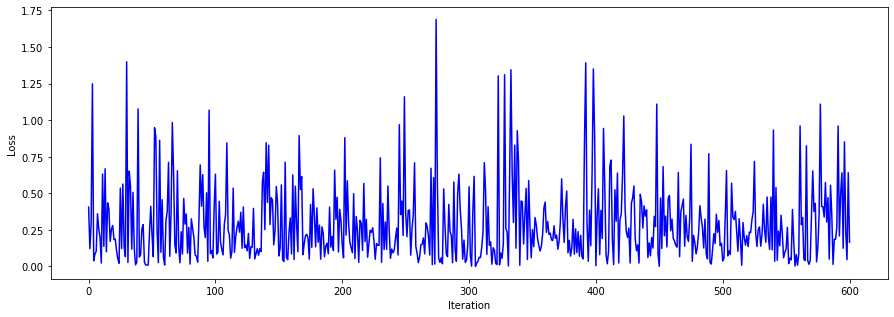

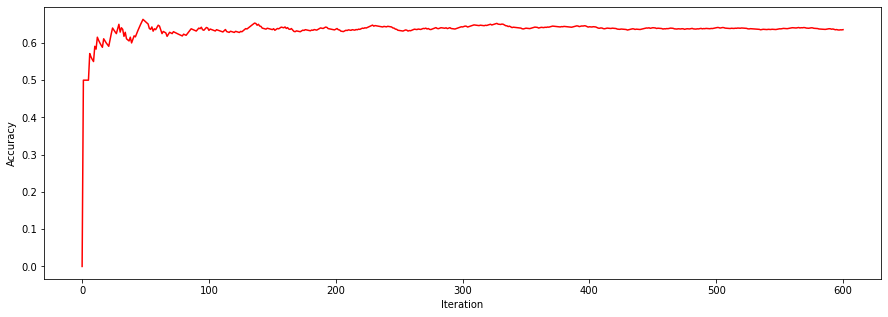

601it [06:18,  1.43it/s]

Loss: 0.289843344198677, all_acc : 0.635607321131448


700it [07:17,  1.67it/s]

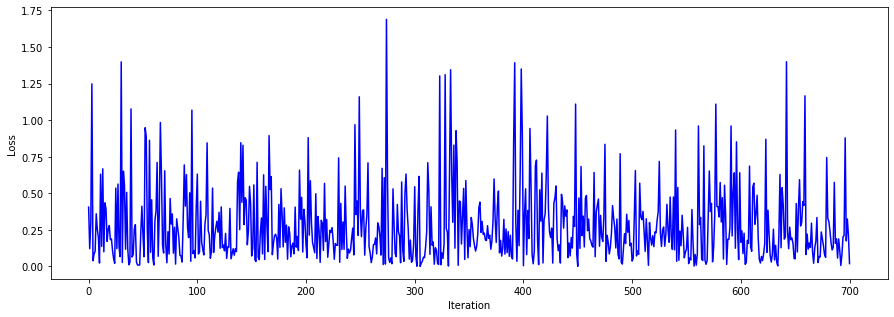

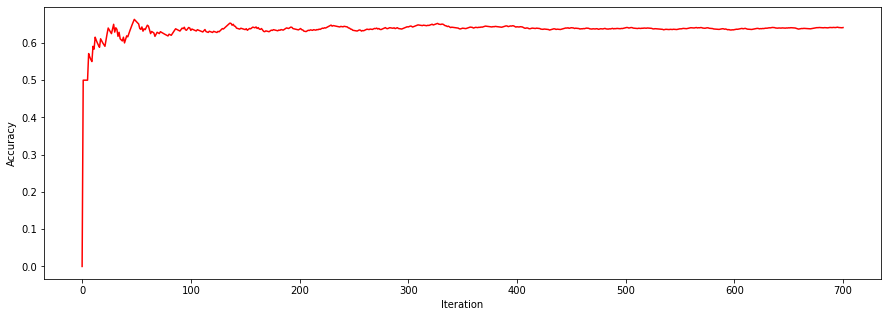

701it [07:17,  1.50it/s]

Loss: 0.2829214701936022, all_acc : 0.6412268188302434


800it [08:17,  1.65it/s]

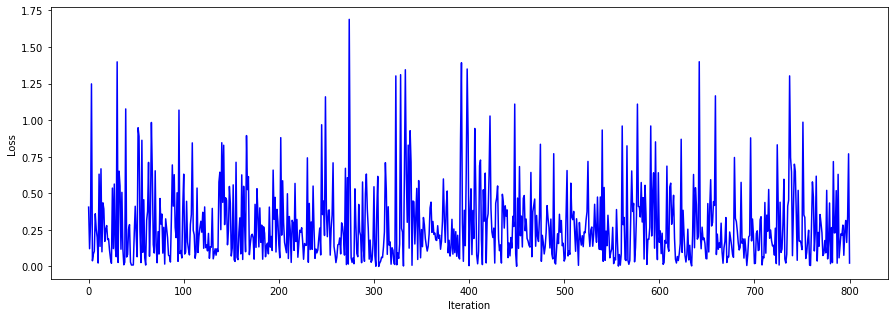

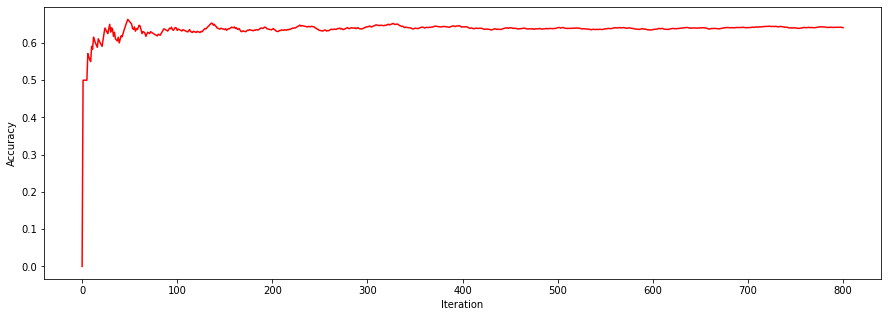

801it [08:17,  1.42it/s]

Loss: 0.2816592782187757, all_acc : 0.6410736579275911


900it [09:16,  1.75it/s]

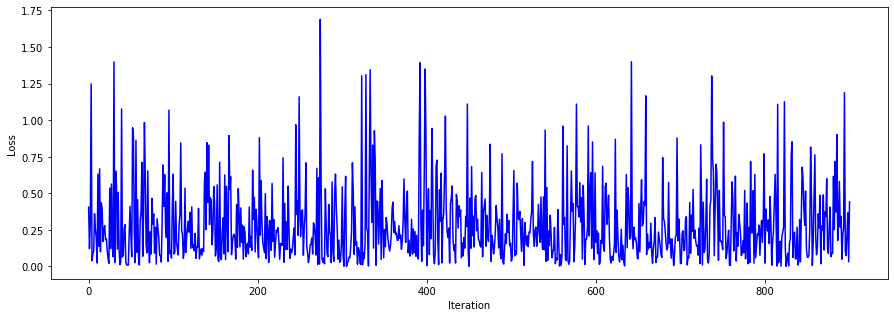

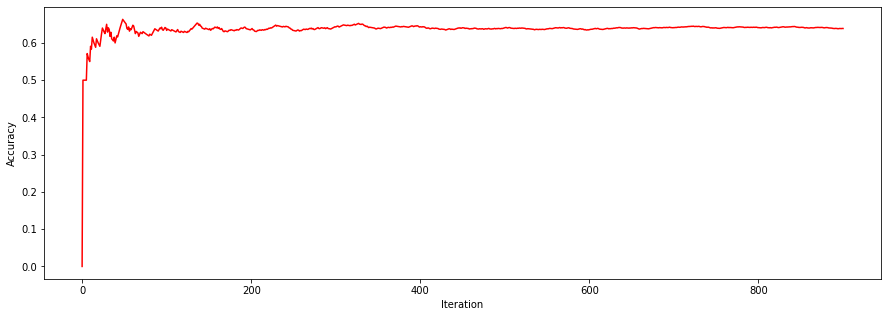

901it [09:17,  1.40it/s]

Loss: 0.2830496239414533, all_acc : 0.6387347391786908


1000it [10:17,  1.52it/s]

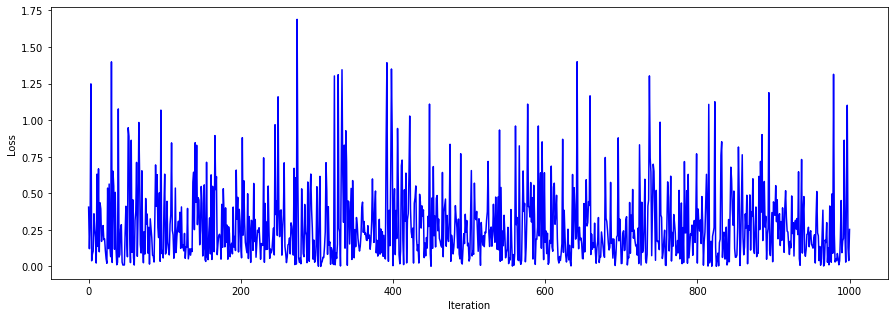

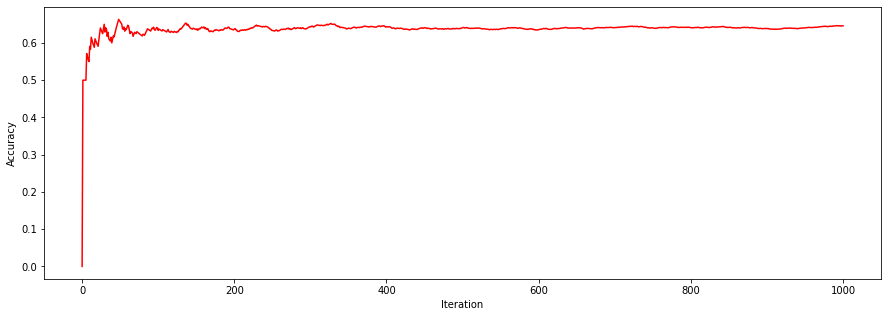

1001it [10:18,  1.40it/s]

Loss: 0.2791859768620054, all_acc : 0.6458541458541464


1100it [11:18,  1.68it/s]

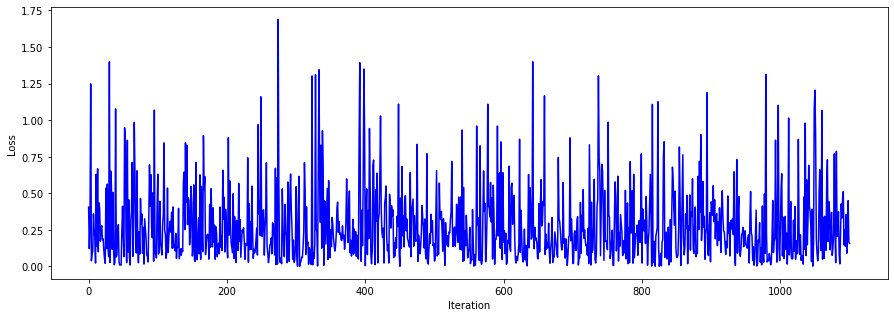

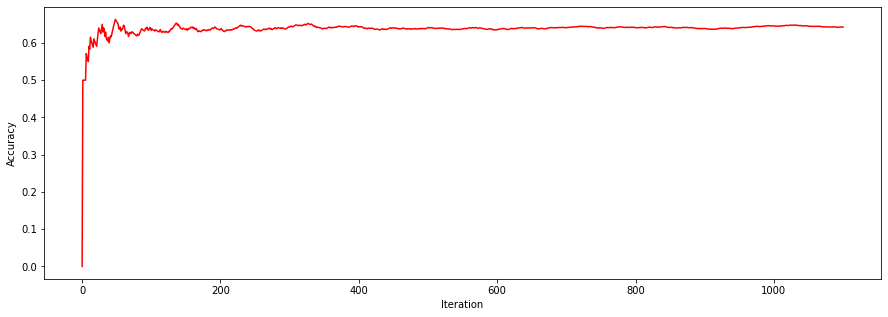

1101it [11:19,  1.42it/s]

Loss: 0.2809427831832977, all_acc : 0.6425976385104457


1200it [12:18,  1.82it/s]

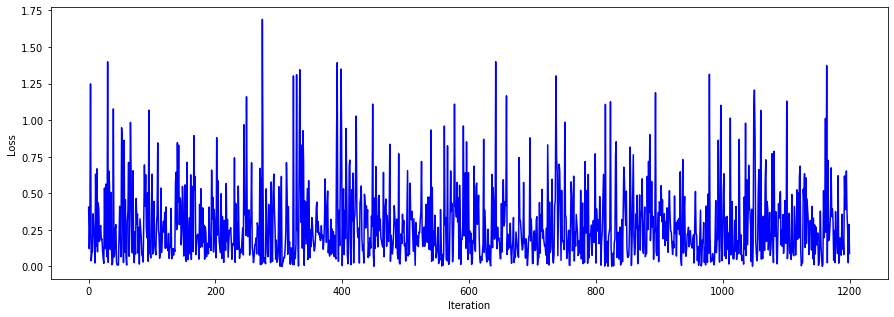

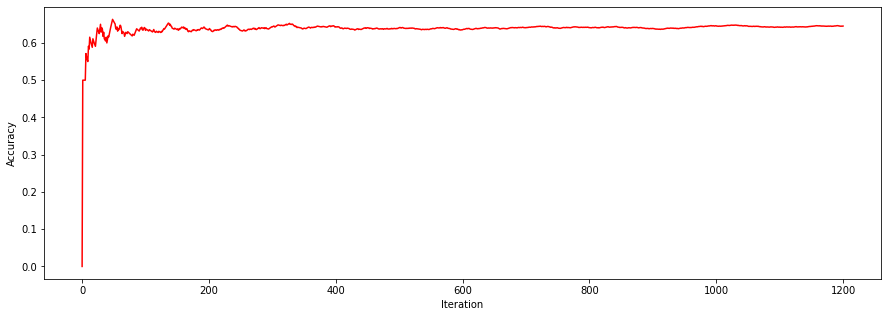

1201it [12:19,  1.46it/s]

Loss: 0.2805529051721751, all_acc : 0.6452955870108247


1300it [13:18,  1.67it/s]

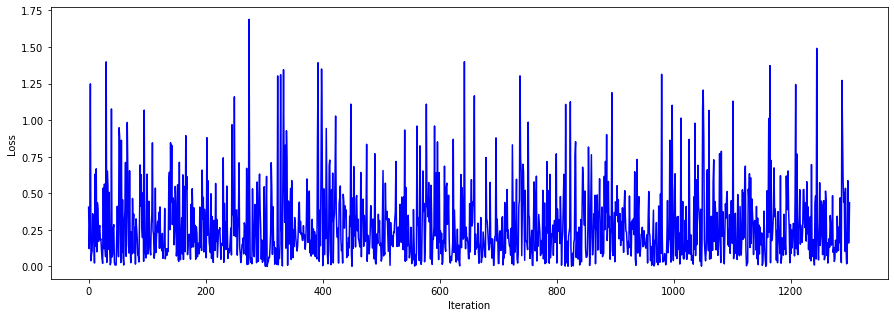

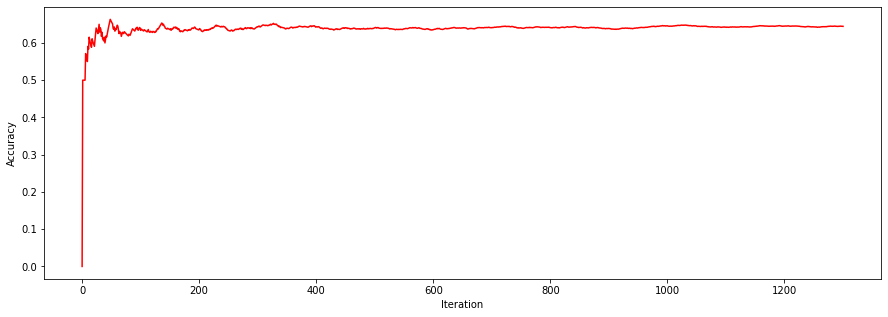

1301it [13:19,  1.47it/s]

Loss: 0.2813084674725752, all_acc : 0.6445042275172956


1400it [14:18,  1.64it/s]

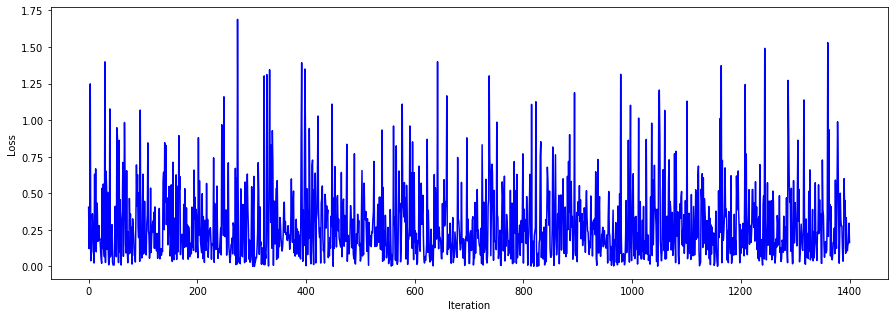

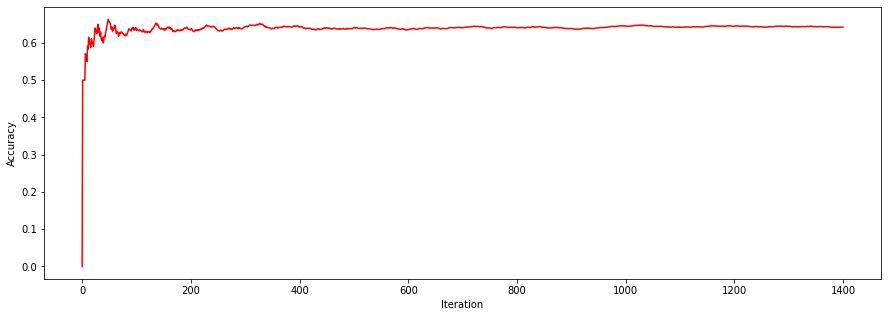

1401it [14:19,  1.36it/s]

Loss: 0.2813453163623329, all_acc : 0.6423982869379024


1500it [15:20,  1.53it/s]

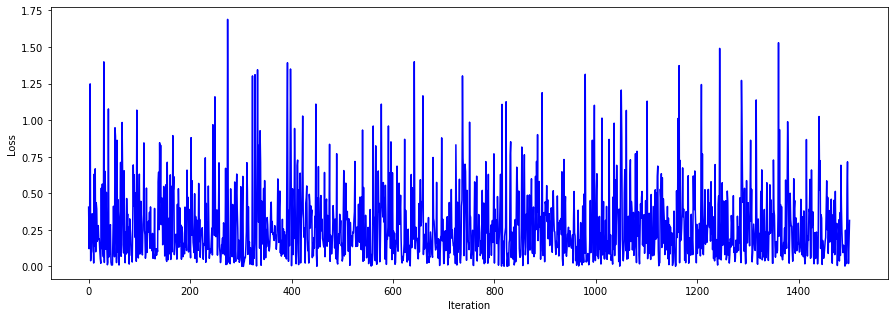

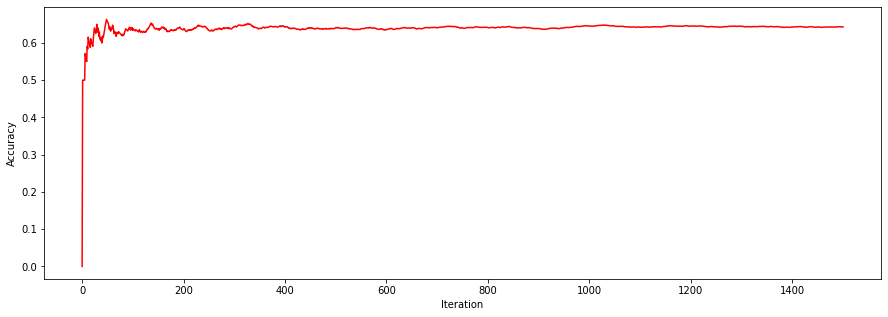

1501it [15:21,  1.36it/s]

Loss: 0.27911901746217754, all_acc : 0.6432378414390411


1600it [16:20,  1.66it/s]

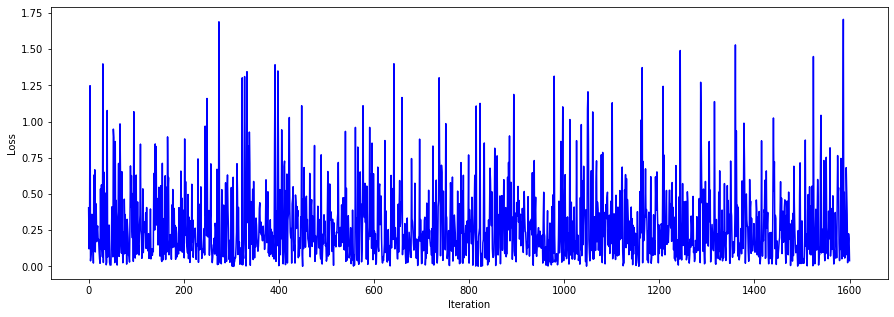

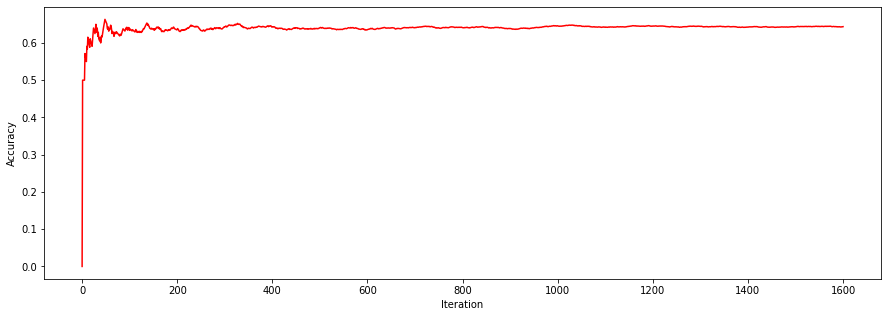

1601it [16:21,  1.40it/s]

Loss: 0.28011304592943637, all_acc : 0.6436602123672713


1700it [17:21,  1.60it/s]

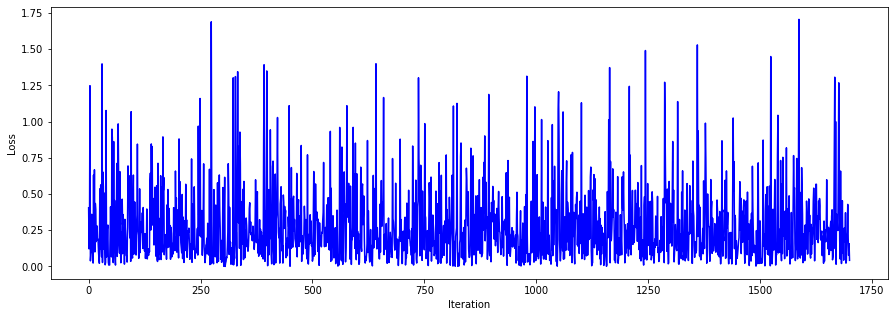

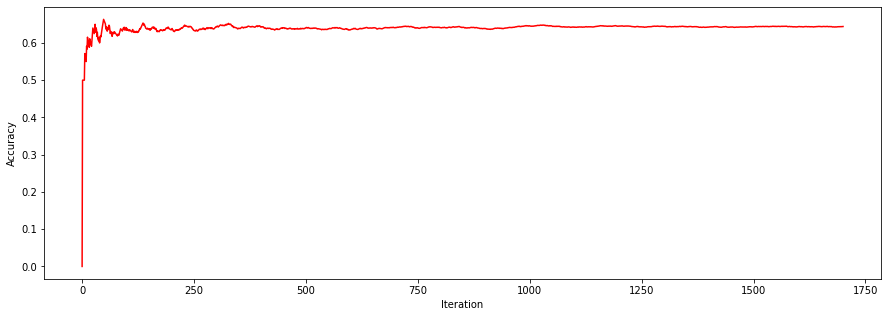

1701it [17:22,  1.37it/s]

Loss: 0.2800364301164978, all_acc : 0.6440329218107004


1800it [18:19,  1.68it/s]

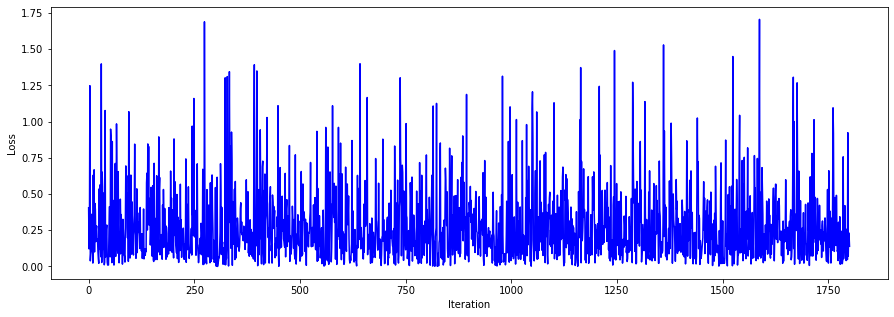

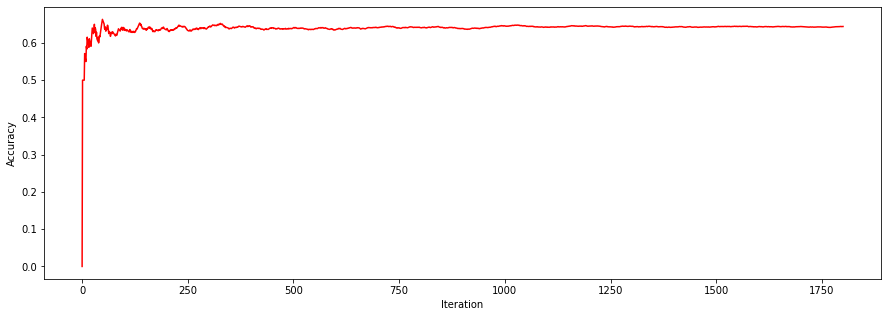

1801it [18:20,  1.40it/s]

Loss: 0.27876295735387946, all_acc : 0.6440866185452534


1900it [19:20,  1.63it/s]

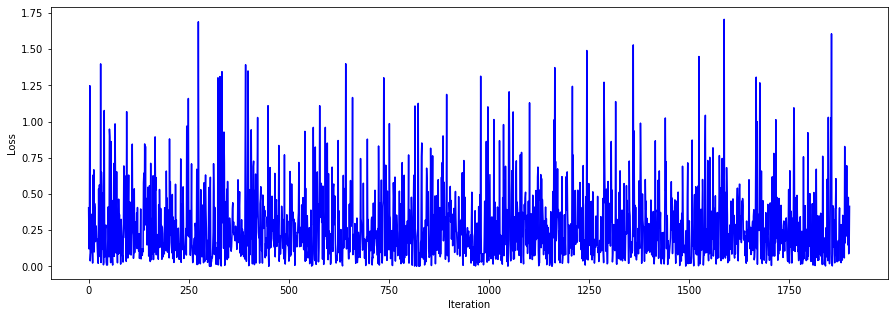

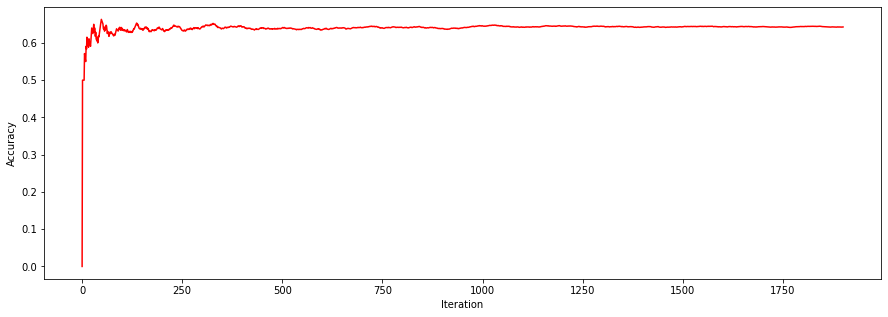

1901it [19:21,  1.40it/s]

Loss: 0.2771304526047177, all_acc : 0.6428195686480807


2000it [20:20,  1.68it/s]

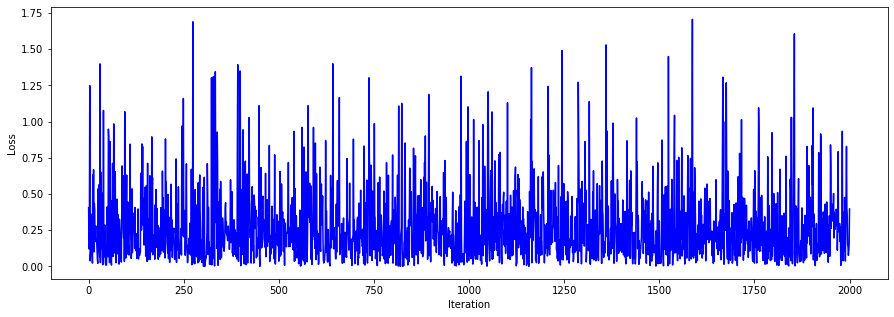

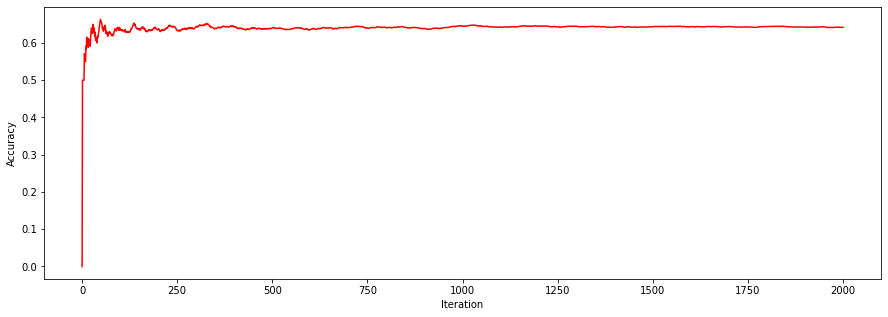

Loss: 0.2778133829578356, all_acc : 0.6419290354822595


2100it [21:29,  1.70it/s]

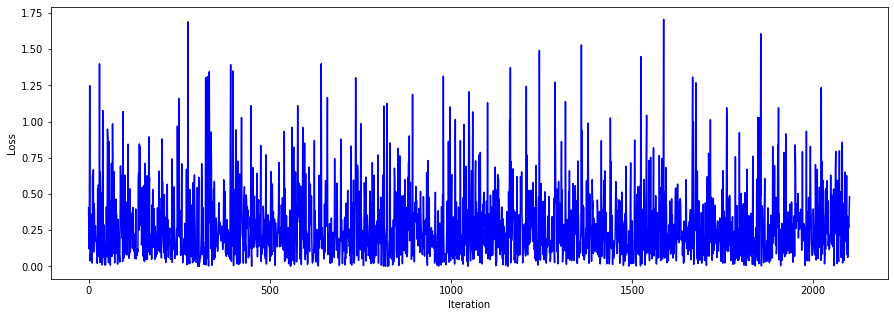

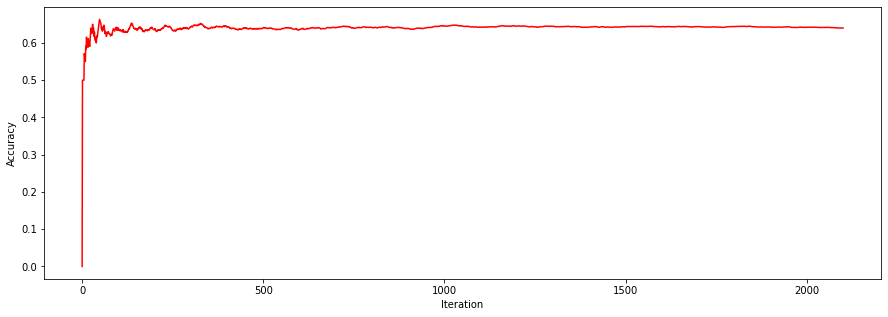

2101it [21:30,  1.41it/s]

Loss: 0.2795176404825148, all_acc : 0.6399333650642558


2200it [22:28,  1.77it/s]

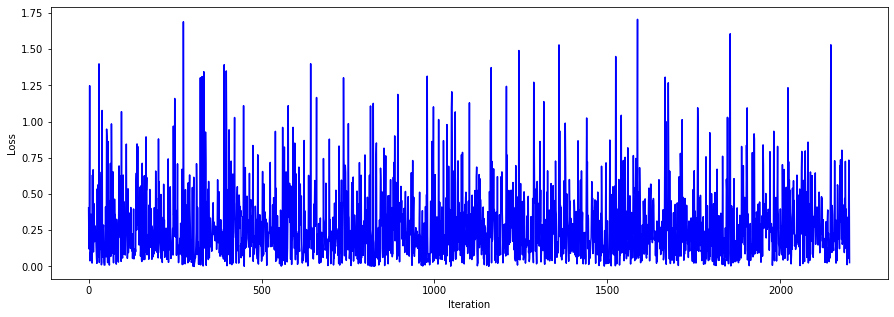

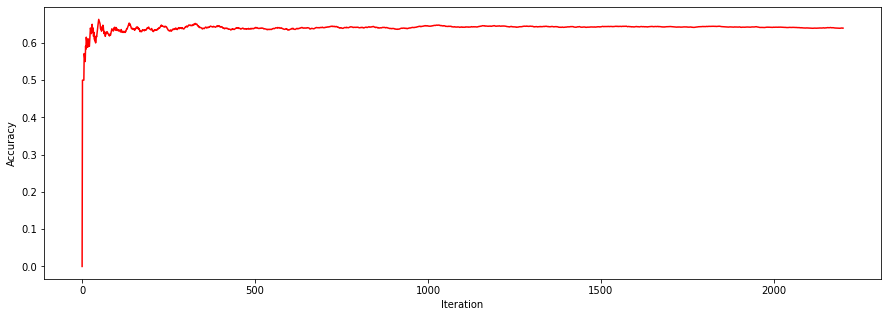

2201it [22:29,  1.45it/s]

Loss: 0.27968627890394343, all_acc : 0.6397092230804187


2300it [23:29,  1.68it/s]

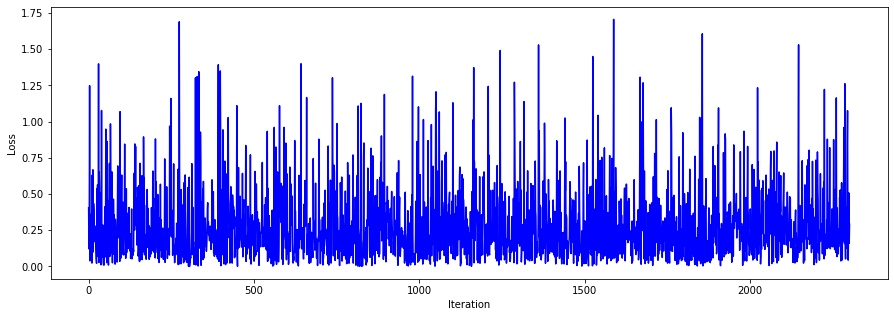

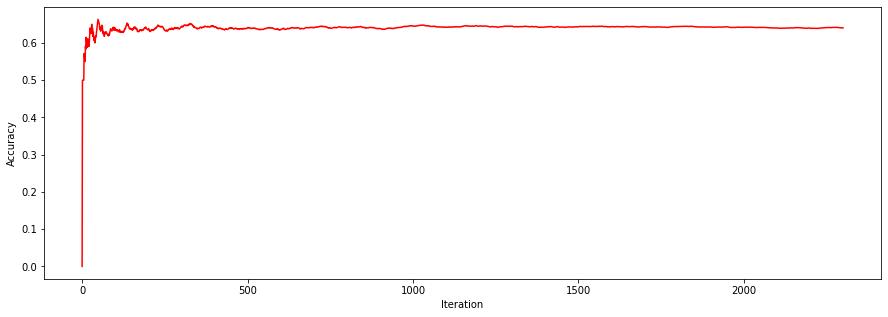

2301it [23:30,  1.45it/s]

Loss: 0.2814873800192707, all_acc : 0.6403737505432424


2400it [24:30,  1.72it/s]

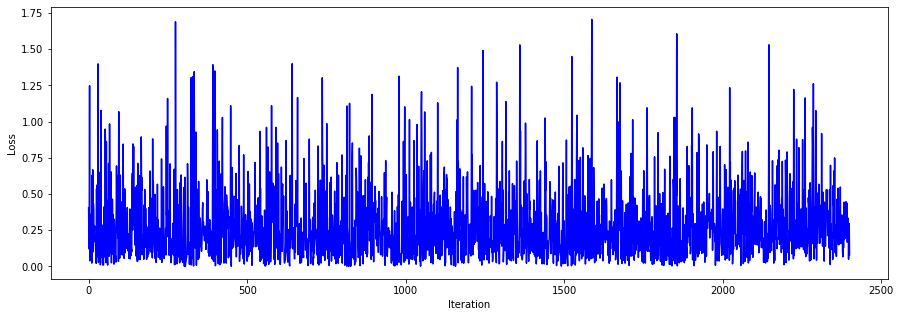

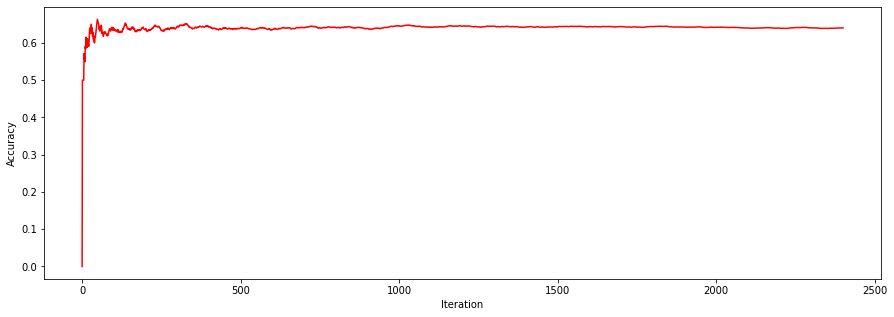

2401it [24:31,  1.44it/s]

Loss: 0.2821356618974208, all_acc : 0.640358184089963


2500it [25:30,  1.68it/s]

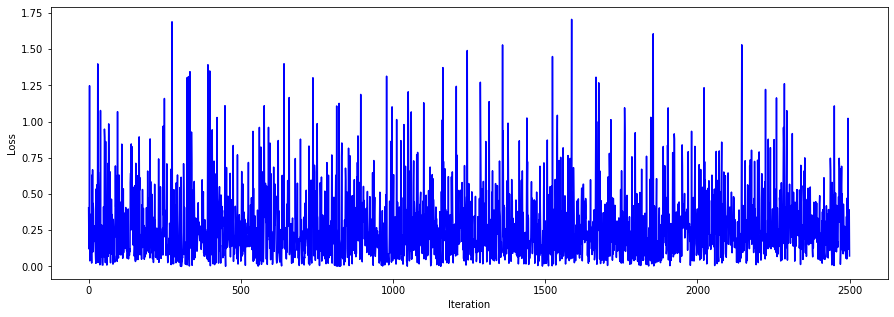

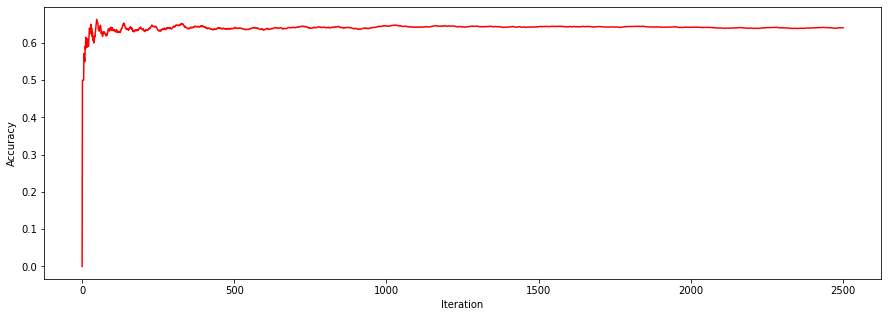

2501it [25:31,  1.43it/s]

Loss: 0.28193885600866947, all_acc : 0.6407437025189933


2600it [26:30,  1.69it/s]

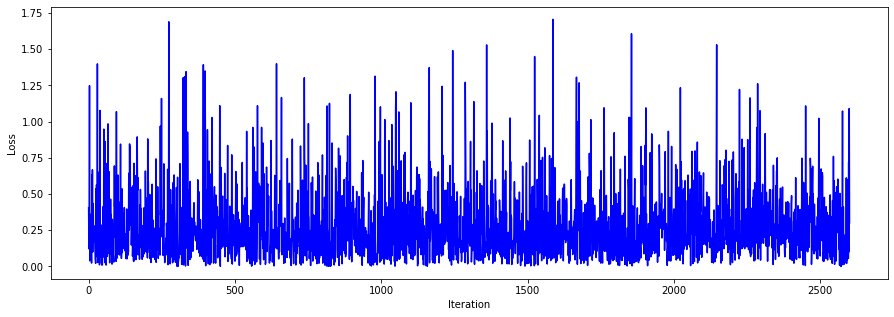

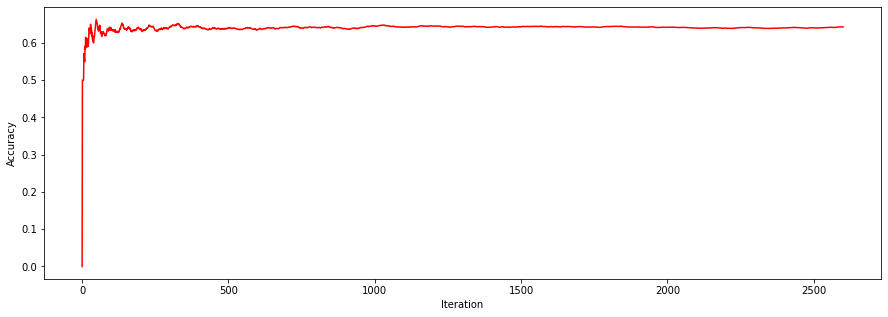

2601it [26:31,  1.48it/s]

Loss: 0.28072949132747516, all_acc : 0.6430219146482125


2700it [27:30,  1.72it/s]

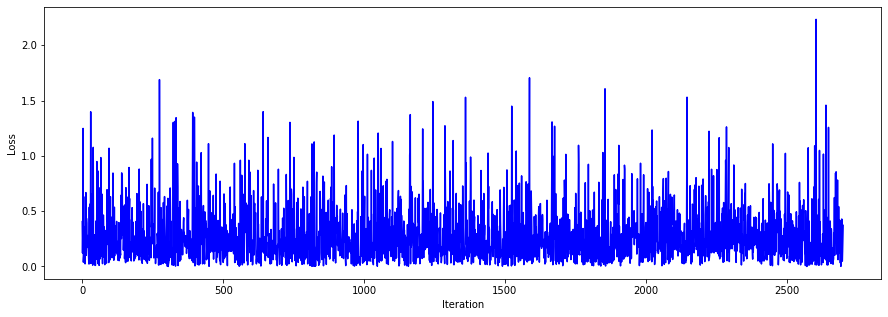

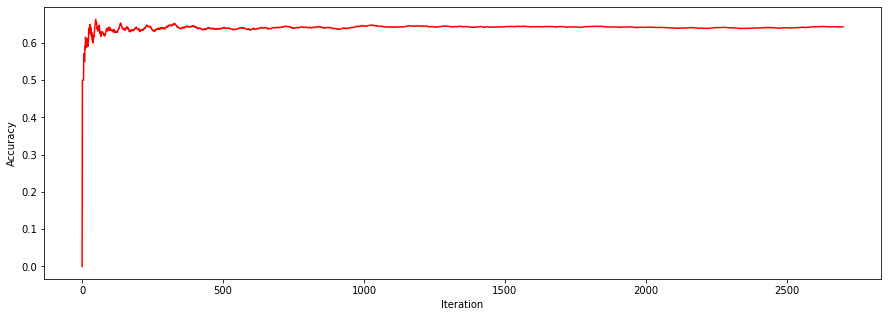

2701it [27:31,  1.50it/s]

Loss: 0.2809313426442868, all_acc : 0.6432802665679387


2800it [28:31,  1.70it/s]

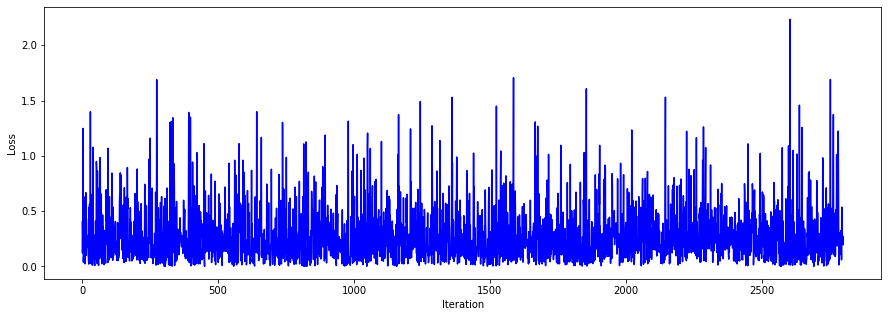

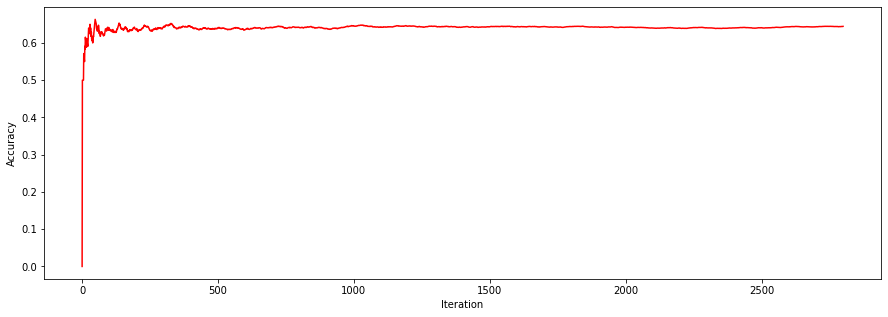

2801it [28:32,  1.48it/s]

Loss: 0.2816397002590805, all_acc : 0.6444127097465195


2900it [29:32,  1.89it/s]

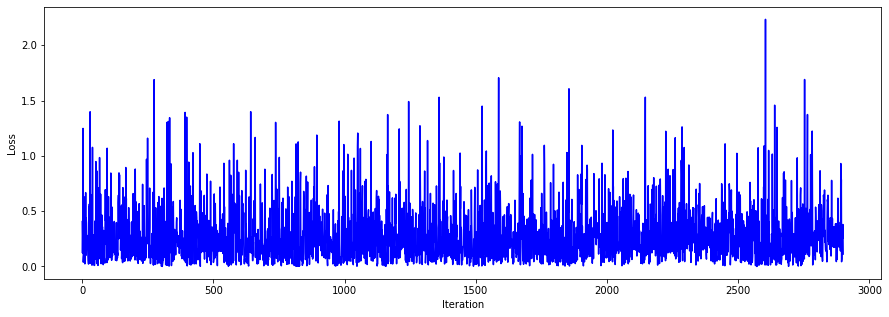

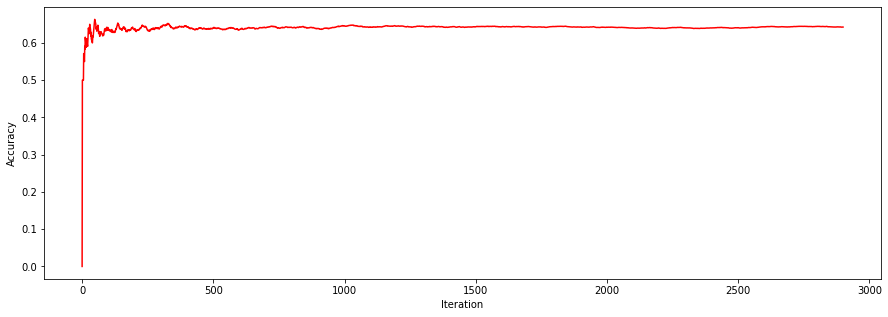

2901it [29:33,  1.58it/s]

Loss: 0.2829465239354883, all_acc : 0.6425370561875222


3000it [30:32,  1.86it/s]

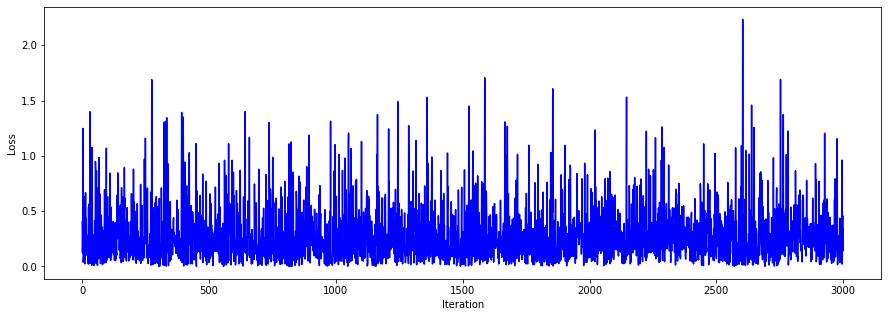

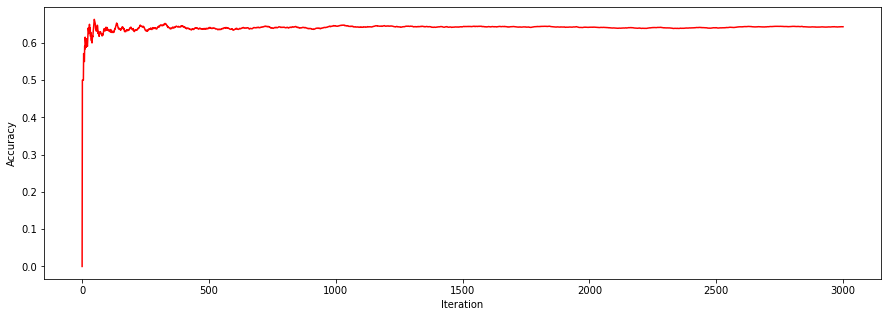

3001it [30:33,  1.51it/s]

Loss: 0.282735217716136, all_acc : 0.643452182605799


3100it [31:31,  1.72it/s]

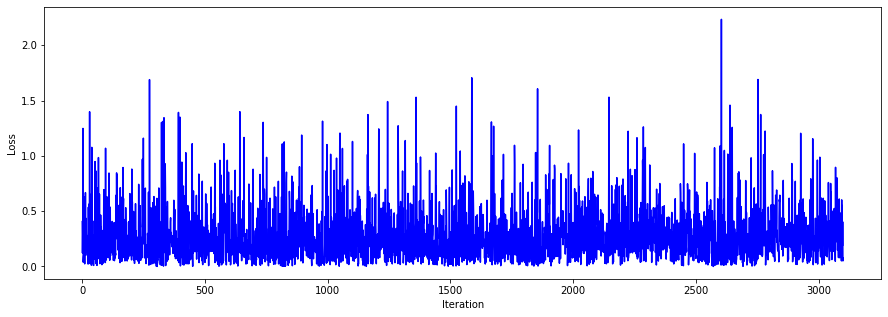

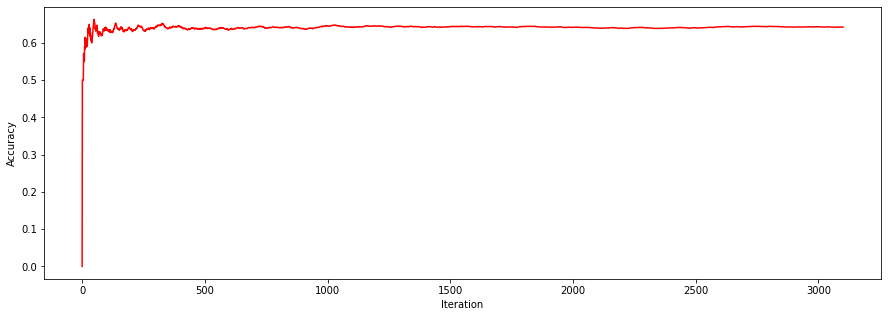

3101it [31:32,  1.38it/s]

Loss: 0.2835448839494973, all_acc : 0.6426959045469208


3200it [32:32,  1.64it/s]

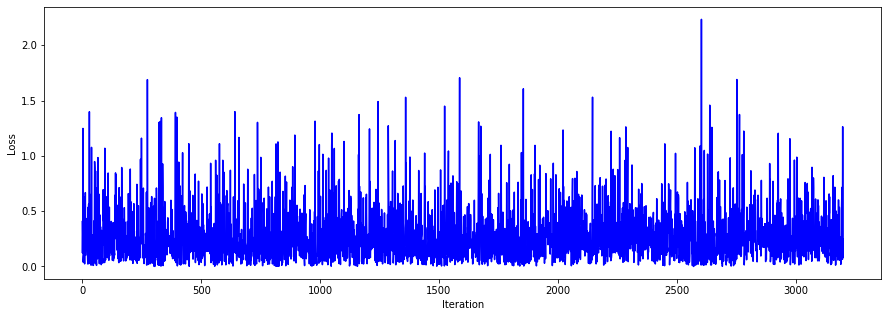

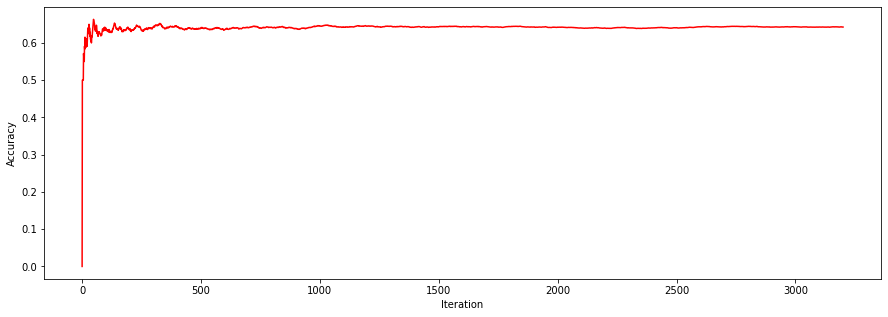

3201it [32:32,  1.45it/s]

Loss: 0.28300447198303746, all_acc : 0.6426116838487981


3300it [33:32,  1.51it/s]

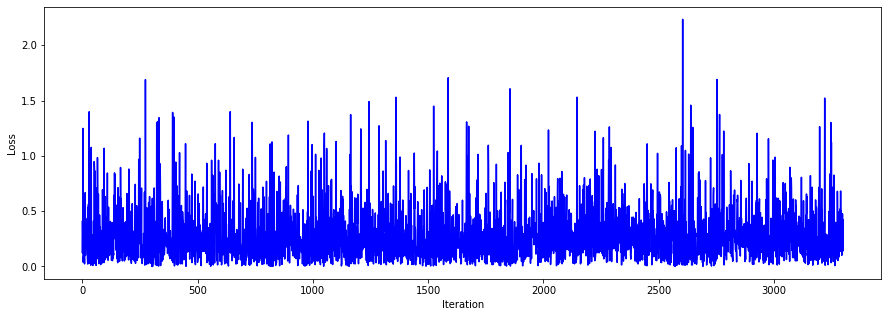

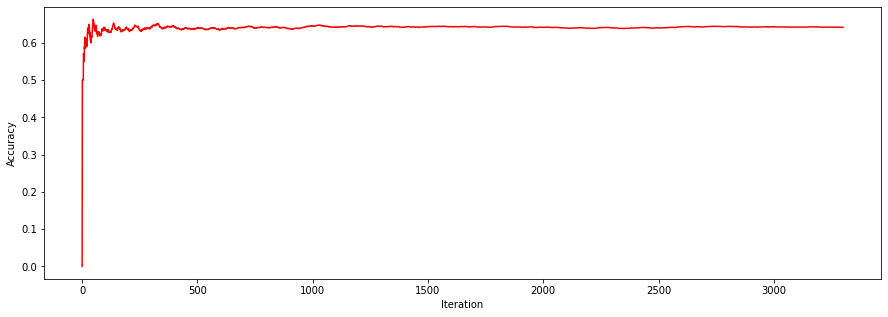

3301it [33:33,  1.28it/s]

Loss: 0.28318610058995347, all_acc : 0.6419266888821578


3400it [34:33,  1.66it/s]

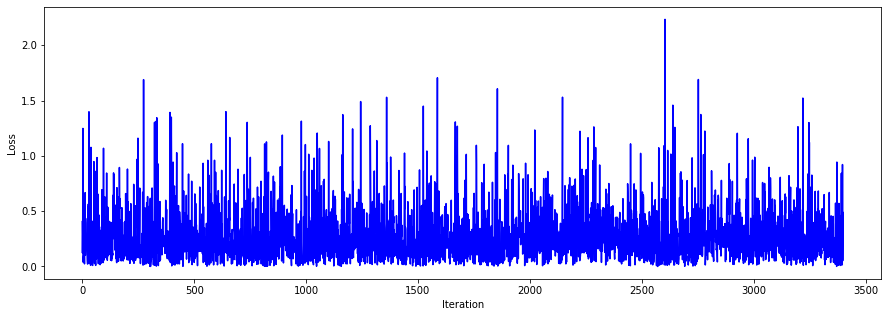

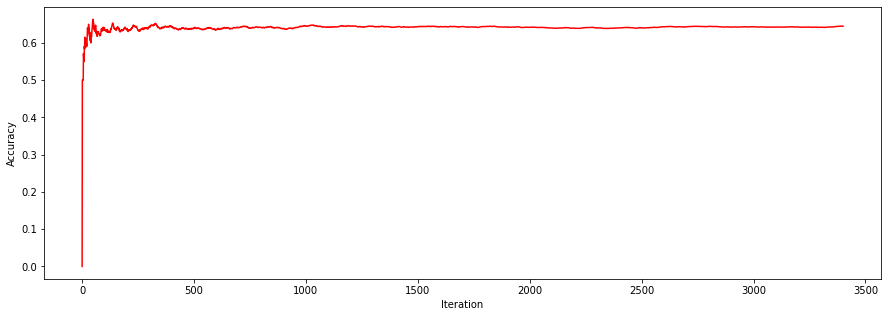

3401it [34:34,  1.33it/s]

Loss: 0.2815088479067785, all_acc : 0.6448103498970899


3500it [35:34,  1.65it/s]

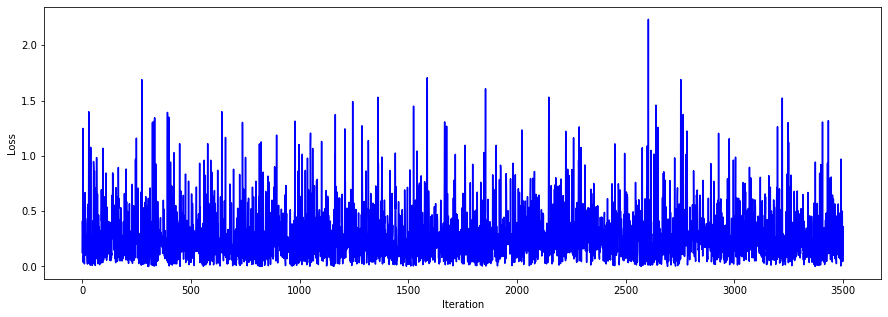

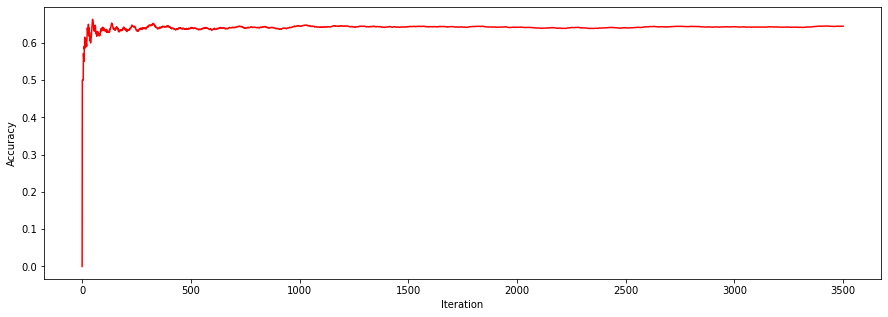

3501it [35:35,  1.36it/s]

Loss: 0.2819194008324207, all_acc : 0.6449585832619259


3600it [36:33,  1.61it/s]

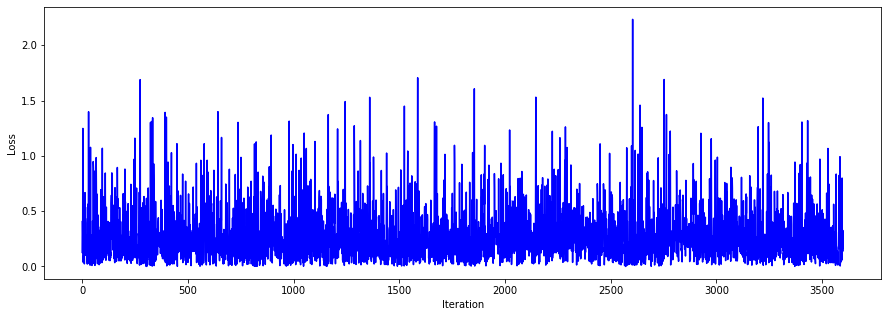

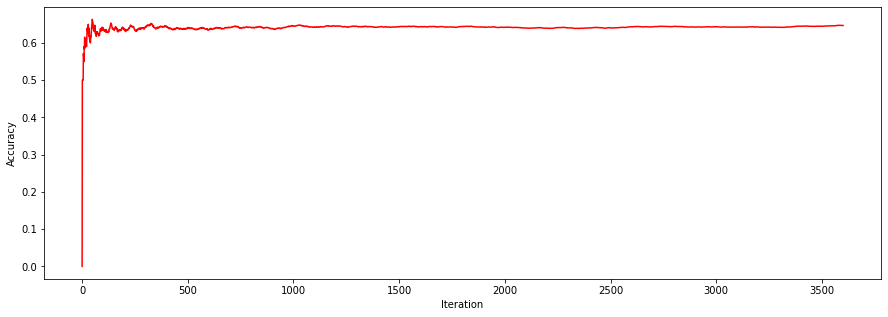

3601it [36:34,  1.40it/s]

Loss: 0.2807166657881881, all_acc : 0.6467647875590121


3700it [37:32,  1.79it/s]

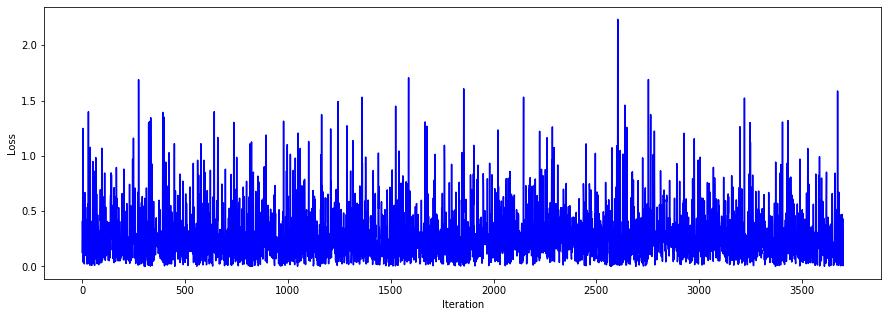

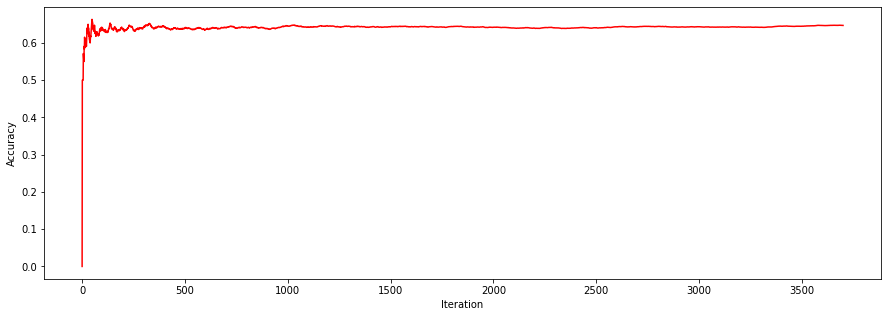

3701it [37:33,  1.44it/s]

Loss: 0.2801035449664326, all_acc : 0.6469873007295333


3800it [38:35,  1.73it/s]

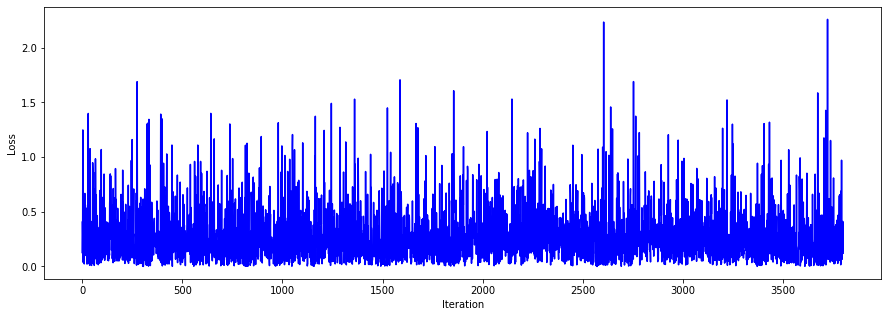

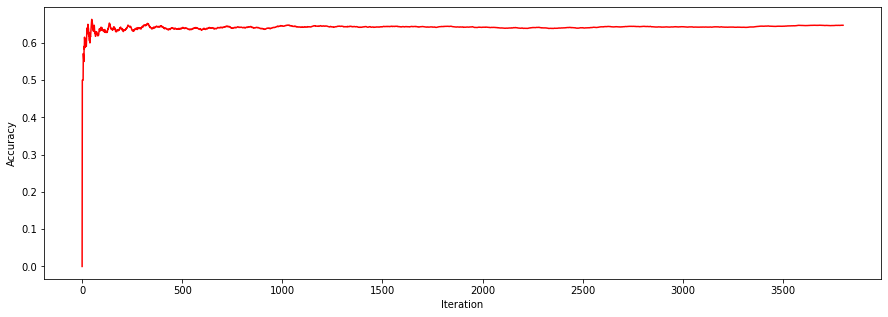

3801it [38:35,  1.47it/s]

Loss: 0.2805710461352409, all_acc : 0.6473296500920818


3900it [39:34,  1.68it/s]

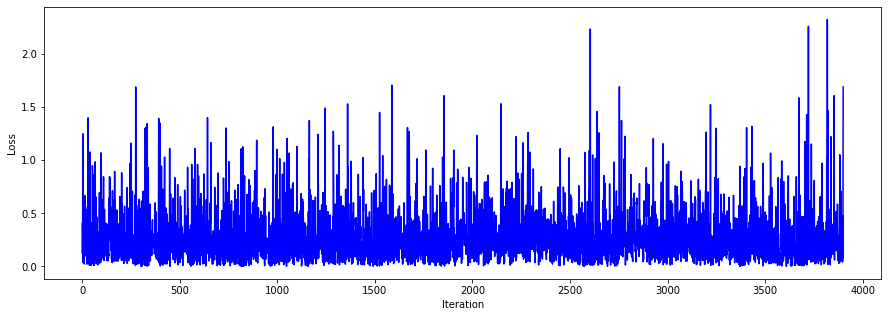

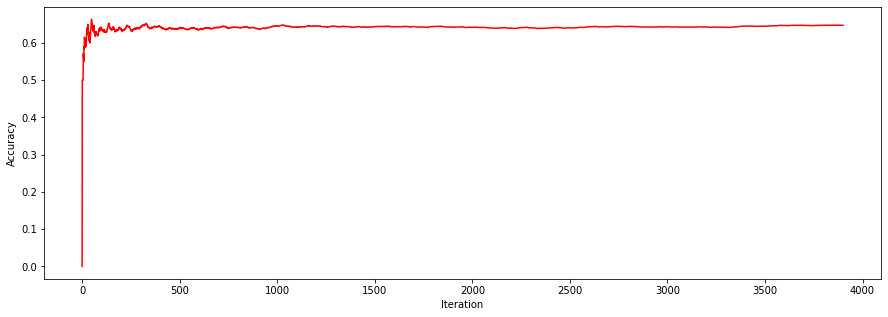

3901it [39:35,  1.41it/s]

Loss: 0.2814541478646912, all_acc : 0.6472699307869784


4000it [40:35,  1.63it/s]

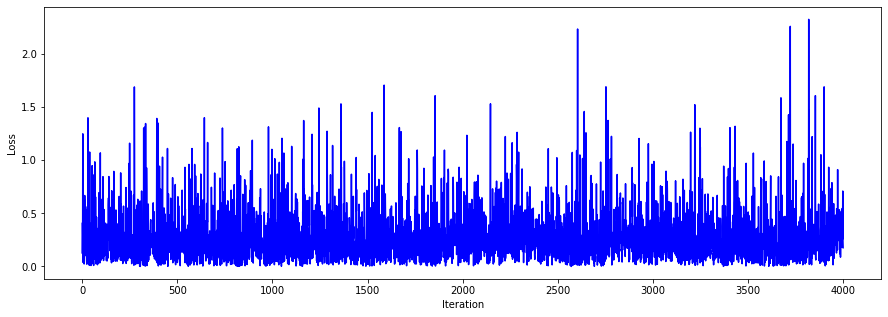

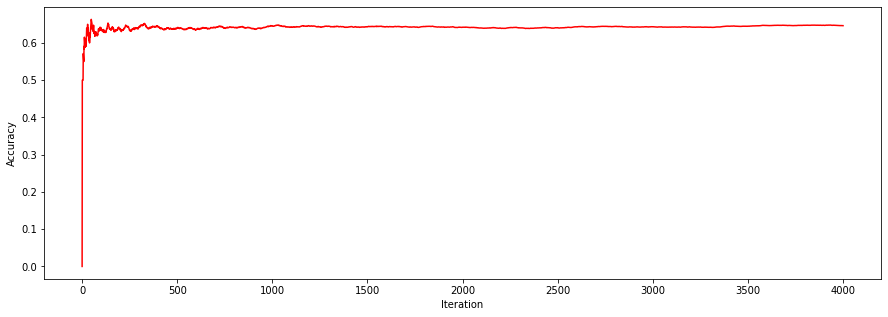

Loss: 0.2823651806783867, all_acc : 0.6463384153961517


4100it [41:43,  1.76it/s]

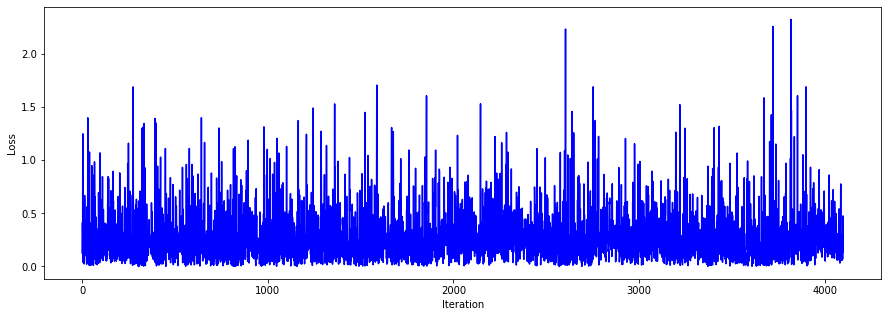

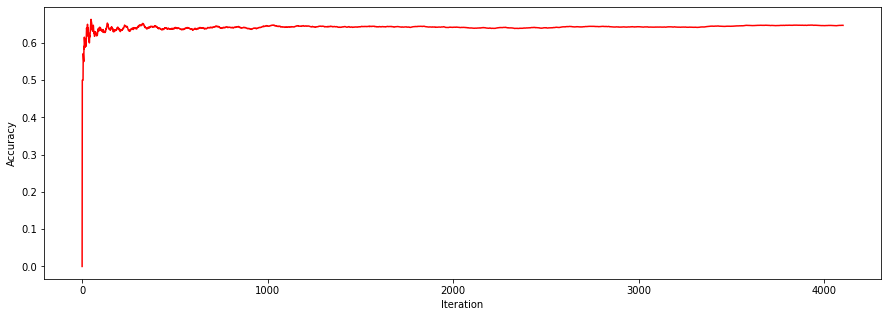

4101it [41:44,  1.44it/s]

Loss: 0.28172496270470515, all_acc : 0.6471592294562308


4200it [42:44,  1.68it/s]

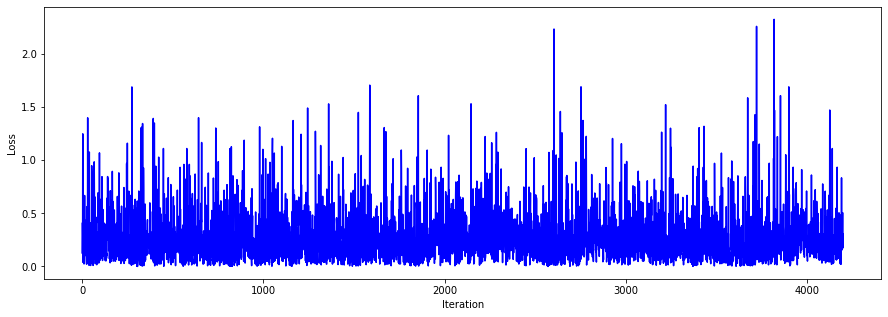

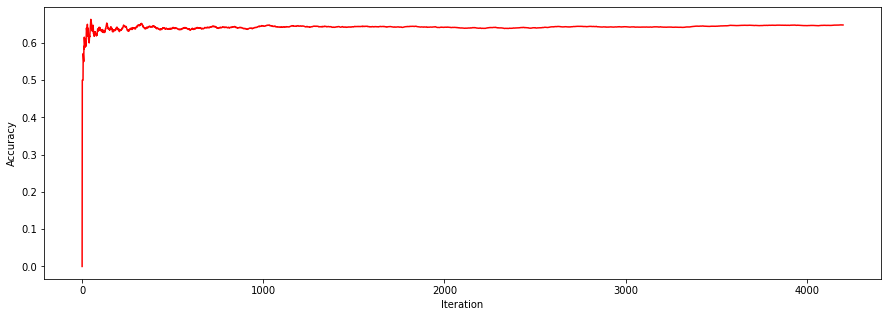

4201it [42:45,  1.42it/s]

Loss: 0.2812082147583851, all_acc : 0.6481790049988105


4300it [43:45,  1.77it/s]

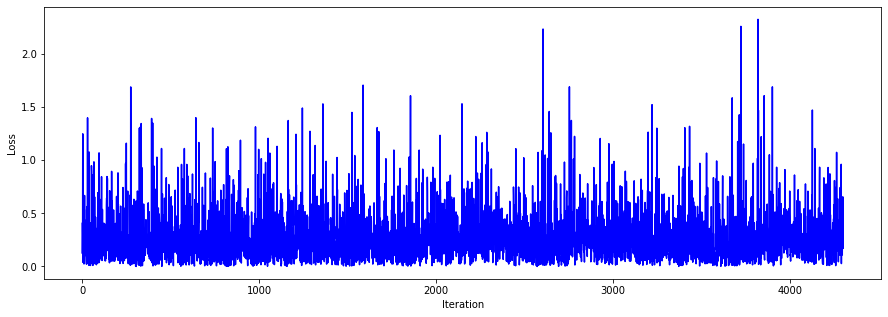

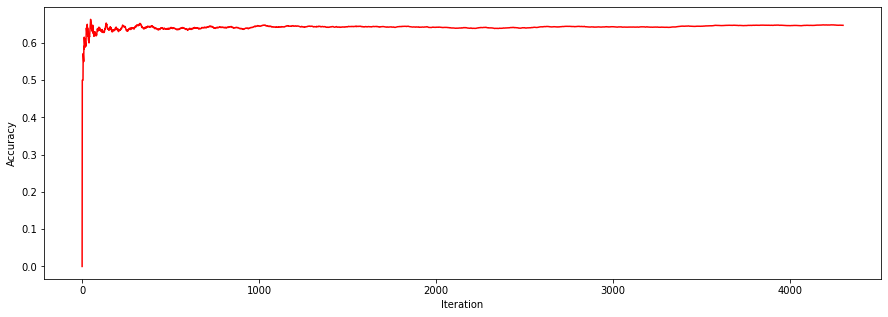

4301it [43:45,  1.52it/s]

Loss: 0.28195444042010276, all_acc : 0.6472913275982337


4400it [44:44,  1.67it/s]

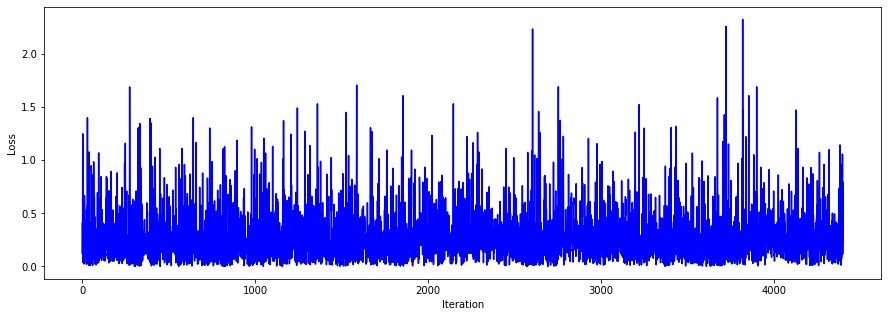

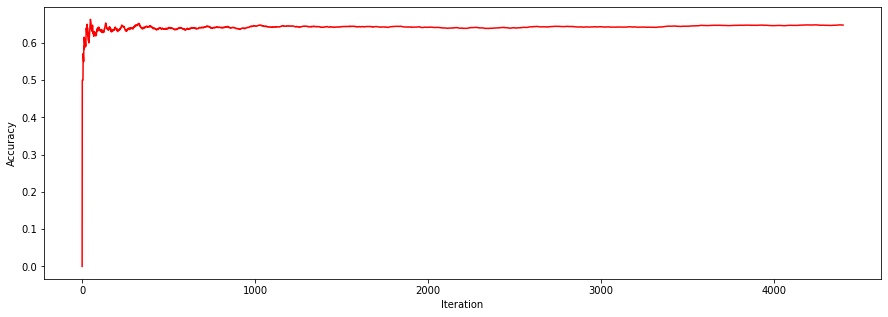

4401it [44:45,  1.46it/s]

Loss: 0.2816669361505308, all_acc : 0.6479209270620325


4500it [45:44,  1.67it/s]

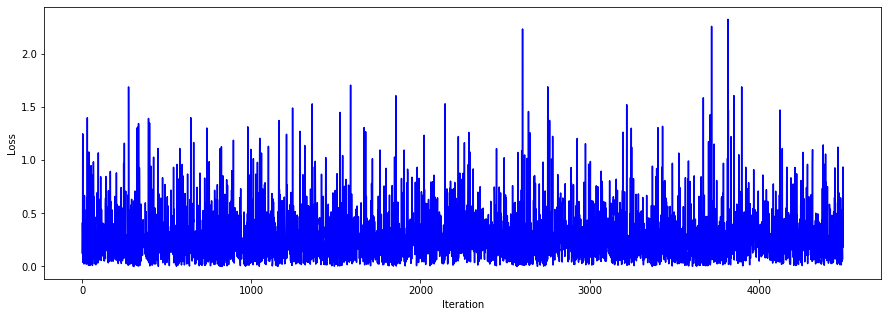

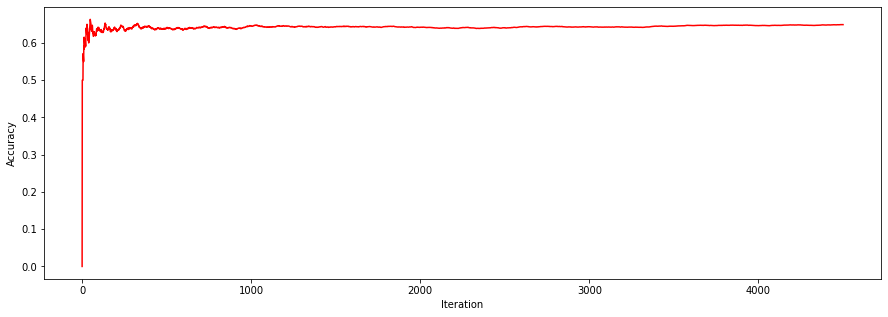

4501it [45:45,  1.46it/s]

Loss: 0.2812047345429973, all_acc : 0.6490779826705186


4600it [46:46,  1.70it/s]

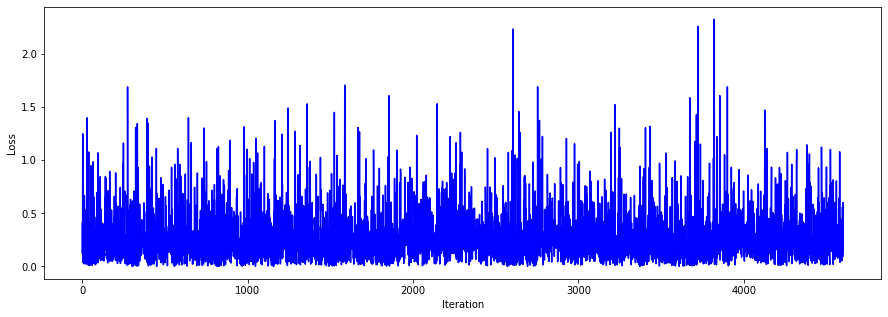

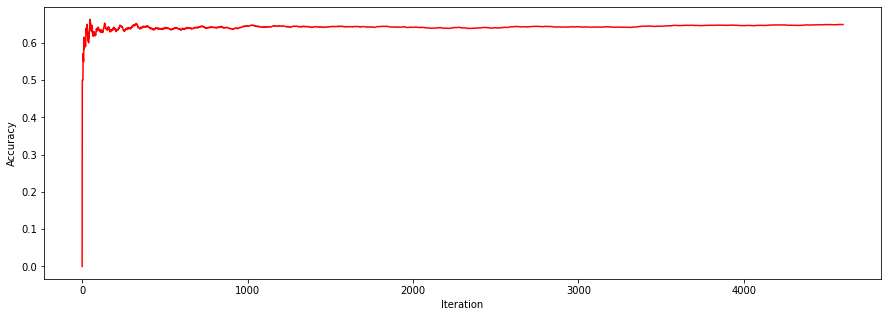

4601it [46:46,  1.53it/s]

Loss: 0.28145631571343394, all_acc : 0.6493153662247343


4700it [47:46,  1.59it/s]

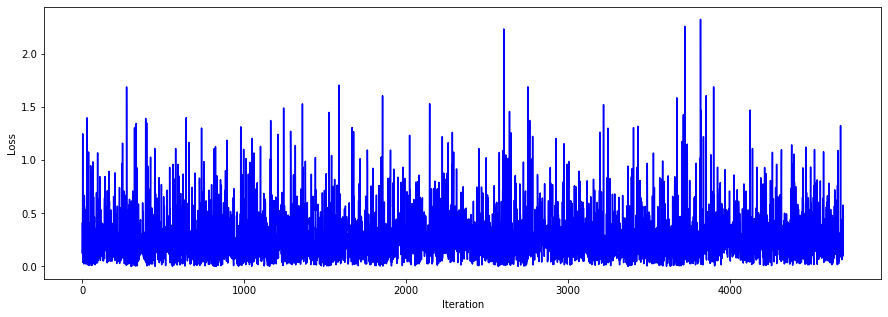

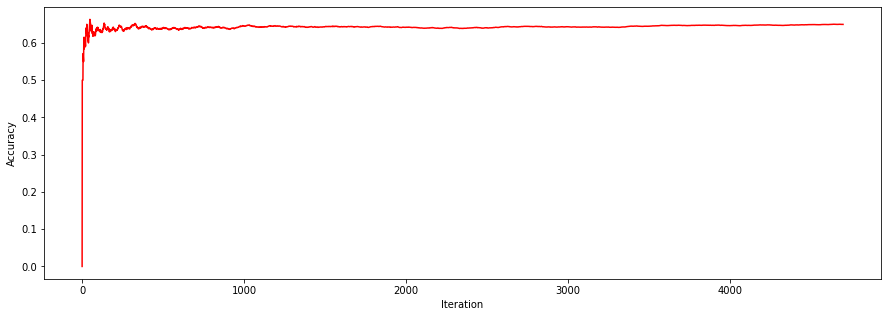

4701it [47:47,  1.35it/s]

Loss: 0.2811442210428631, all_acc : 0.649755371197618


4800it [48:46,  1.64it/s]

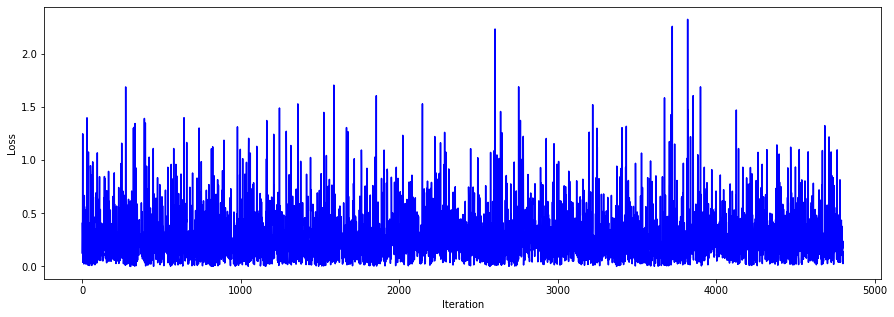

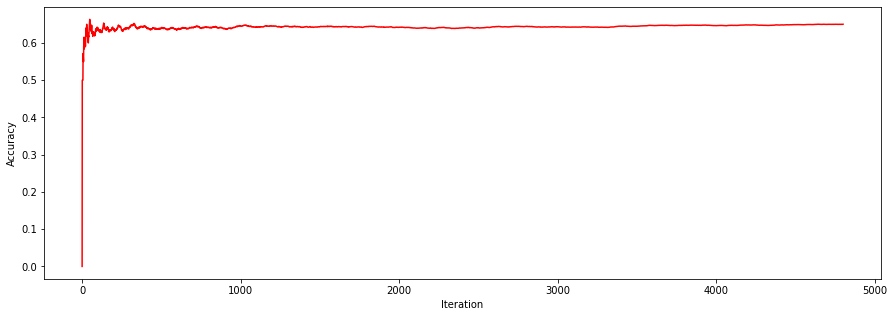

4801it [48:47,  1.40it/s]

Loss: 0.2809396747393279, all_acc : 0.650177046448657


4900it [49:47,  1.71it/s]

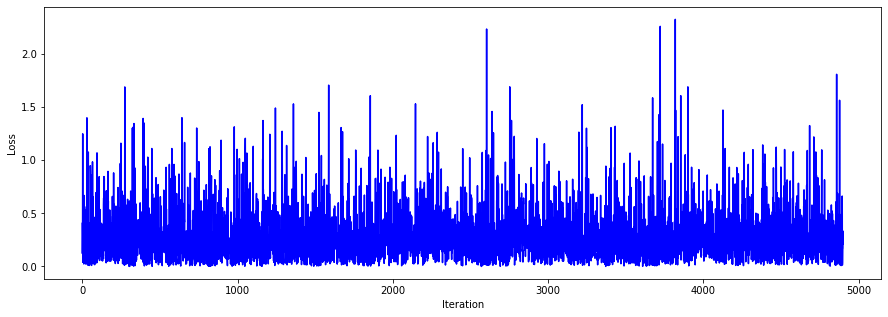

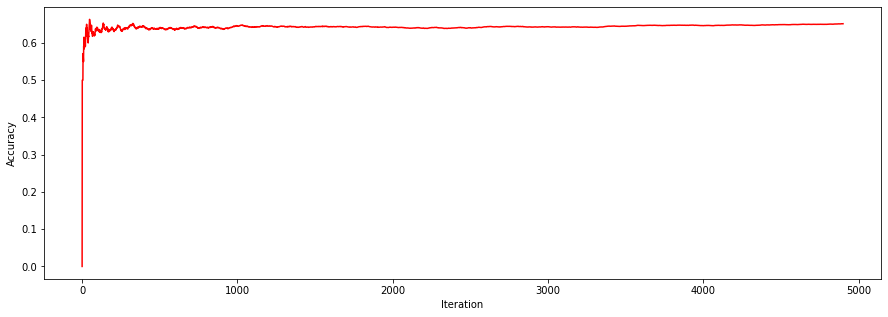

4901it [49:48,  1.43it/s]

Loss: 0.28017453691126437, all_acc : 0.6514996939400123


5000it [50:47,  1.67it/s]

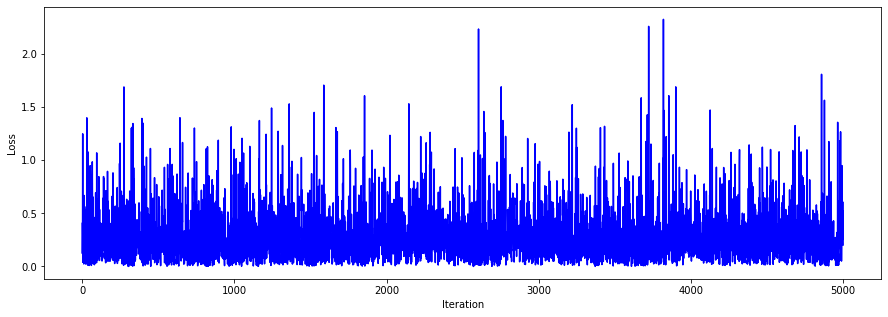

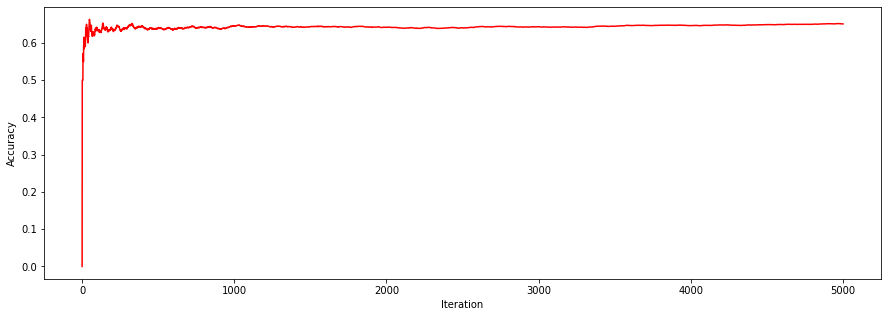

5001it [50:48,  1.37it/s]

Loss: 0.2802982266354944, all_acc : 0.6509698060387921


5100it [51:47,  1.61it/s]

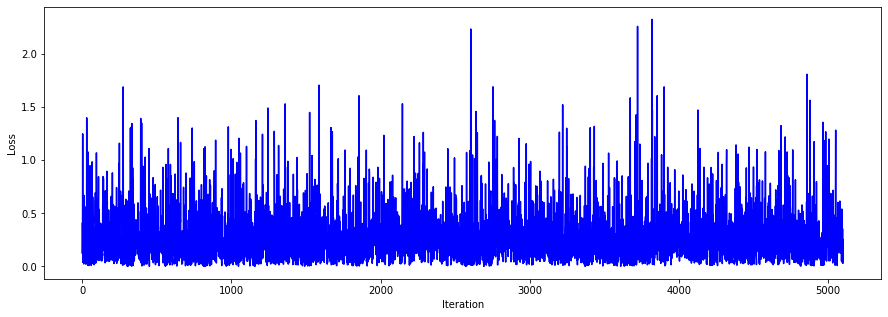

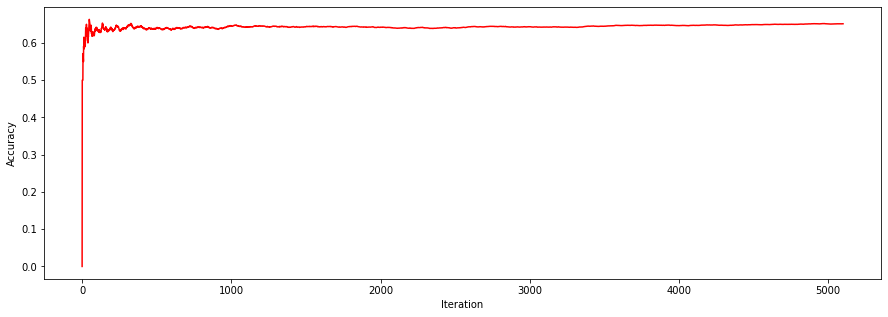

5101it [51:48,  1.33it/s]

Loss: 0.28008807512845124, all_acc : 0.6514408939423639


5200it [52:48,  1.66it/s]

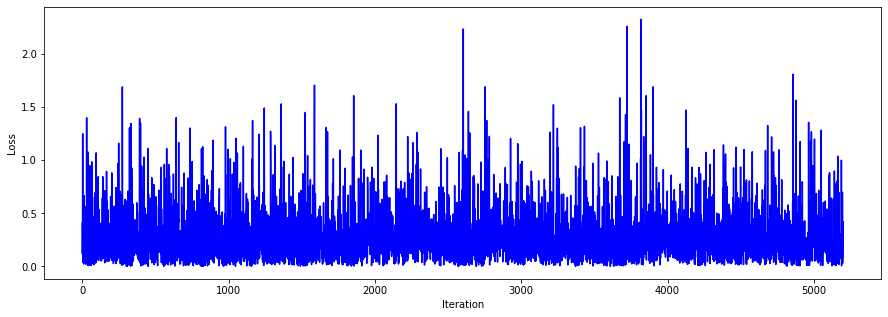

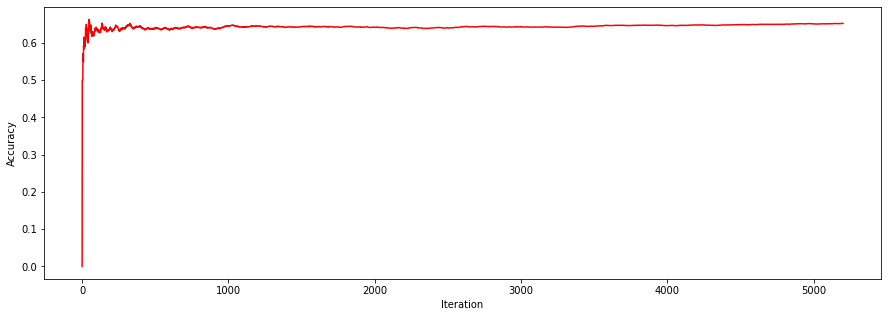

5201it [52:49,  1.38it/s]

Loss: 0.2796128349405632, all_acc : 0.6523745433570464


5300it [53:46,  1.72it/s]

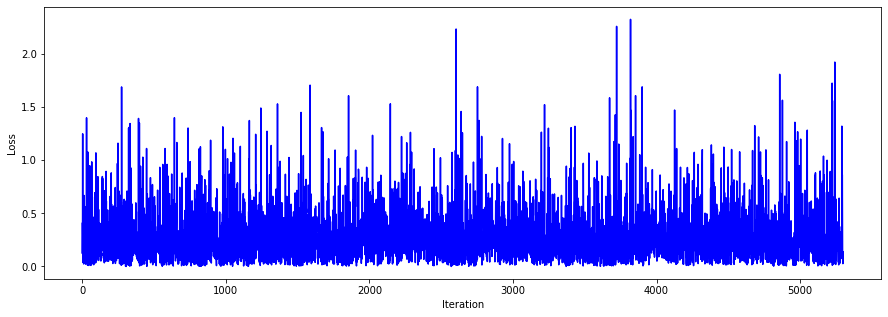

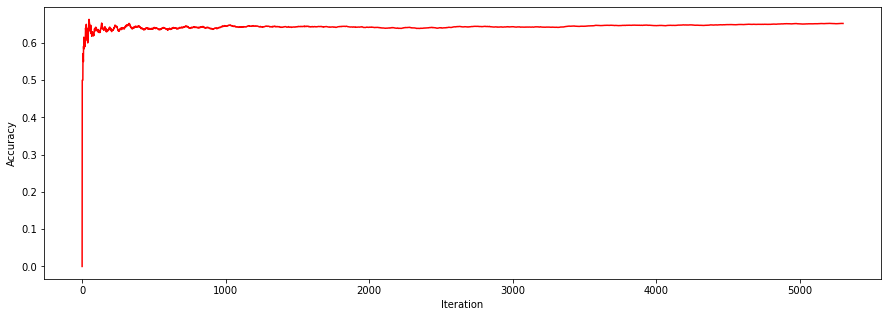

5301it [53:47,  1.42it/s]

Loss: 0.27972892436988916, all_acc : 0.6522354272778714


5400it [54:47,  1.62it/s]

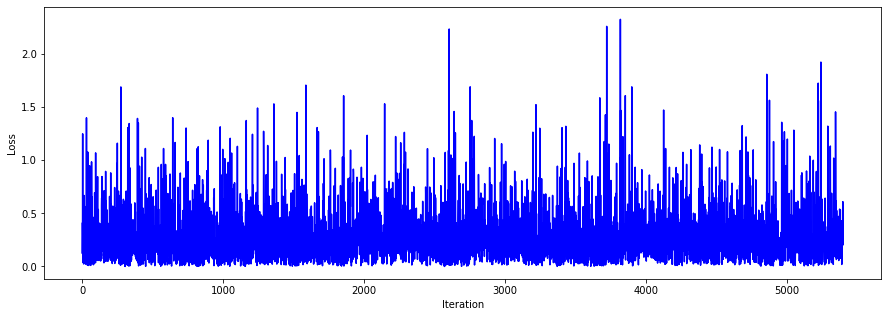

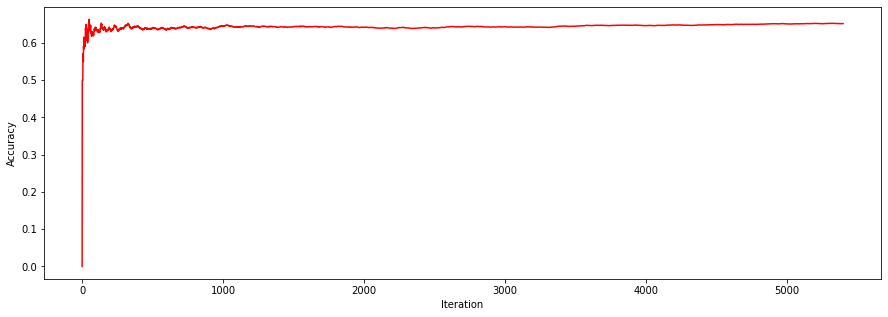

5401it [54:48,  1.37it/s]

Loss: 0.28020608270628733, all_acc : 0.6519163117941114


5500it [55:47,  1.73it/s]

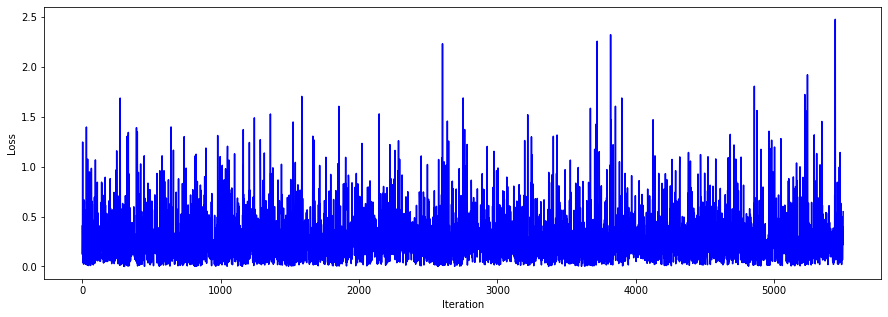

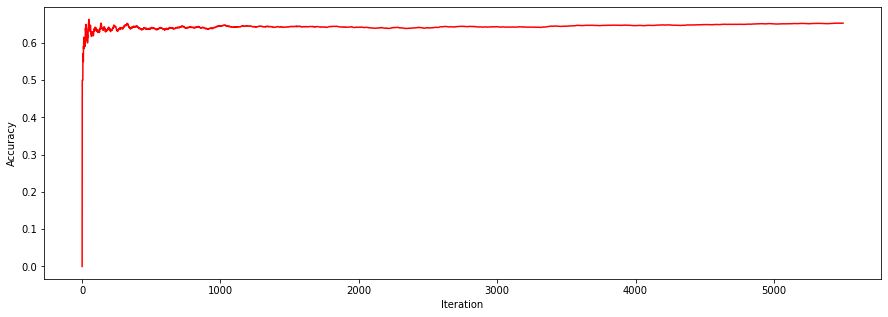

5501it [55:48,  1.42it/s]

Loss: 0.28012722389791117, all_acc : 0.6530630794401012


5600it [56:48,  1.43it/s]

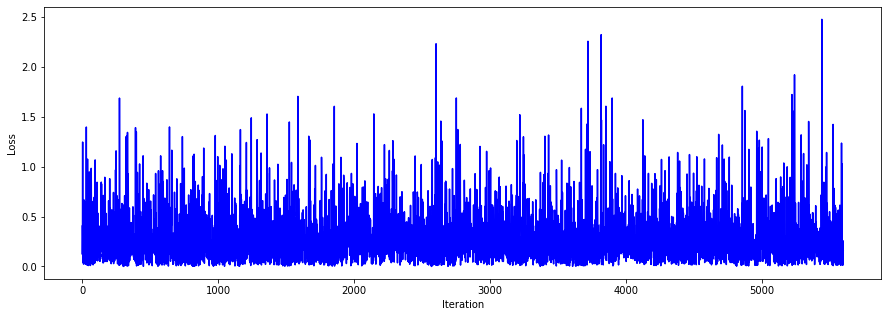

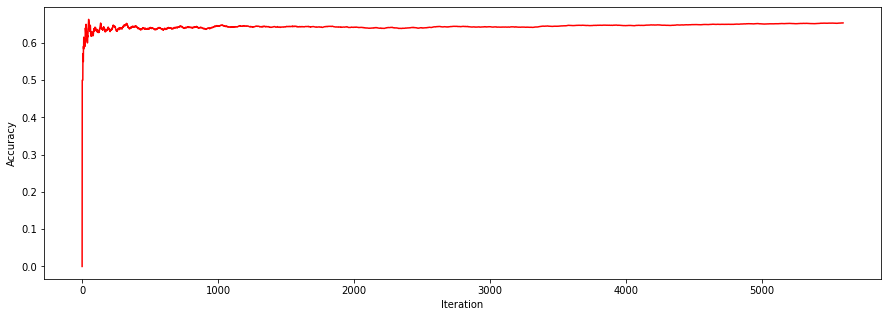

5601it [56:49,  1.27it/s]

Loss: 0.27945849227888736, all_acc : 0.6537225495447242


5700it [57:48,  1.71it/s]

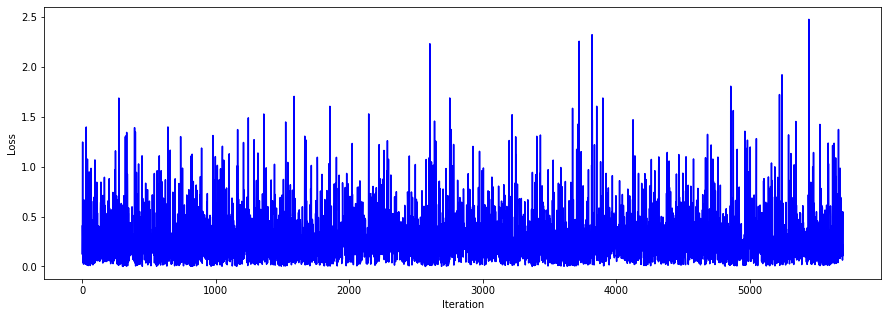

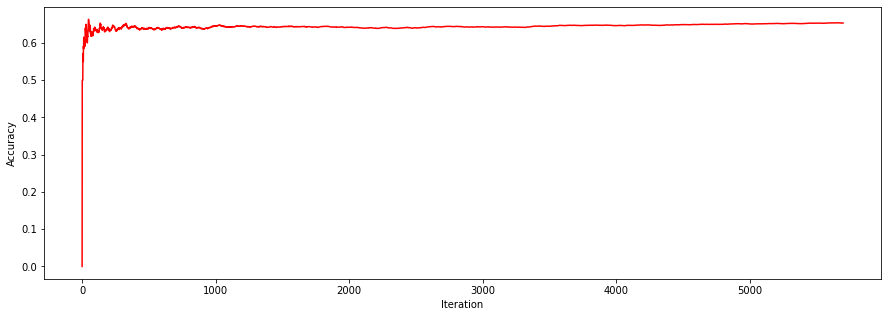

5701it [57:49,  1.44it/s]

Loss: 0.27989832734475073, all_acc : 0.6533941413787057


5800it [58:48,  1.63it/s]

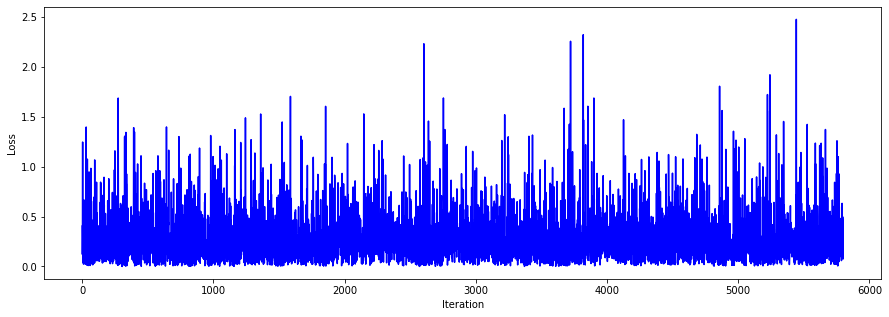

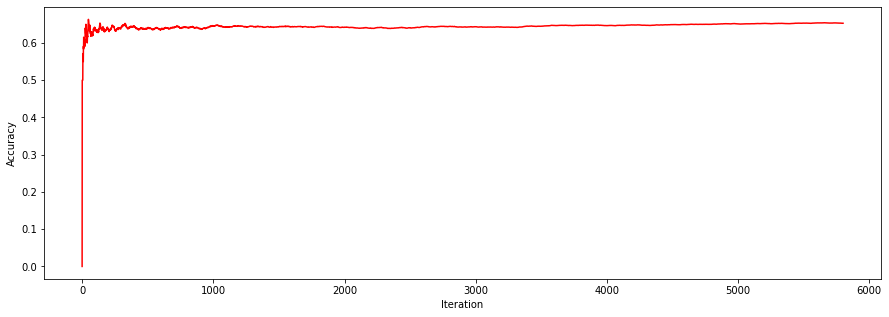

5801it [58:50,  1.34it/s]

Loss: 0.2801947608568994, all_acc : 0.6528184795724876


5900it [59:49,  1.71it/s]

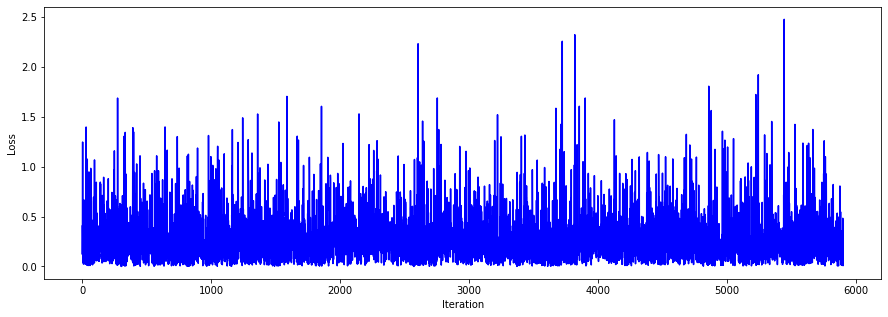

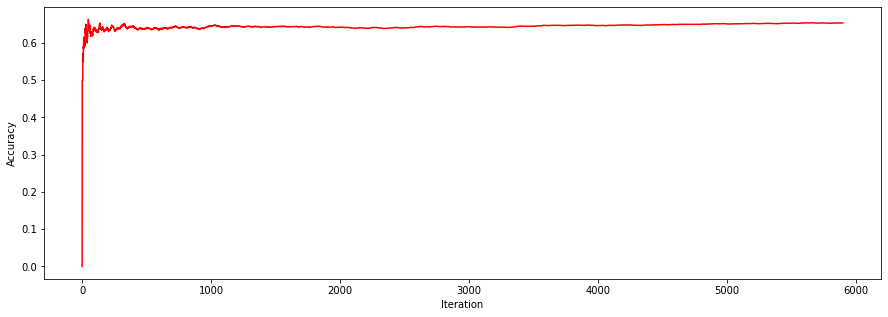

5901it [59:50,  1.41it/s]

Loss: 0.2793878832426429, all_acc : 0.6537874936451455


6000it [1:00:50,  1.83it/s]

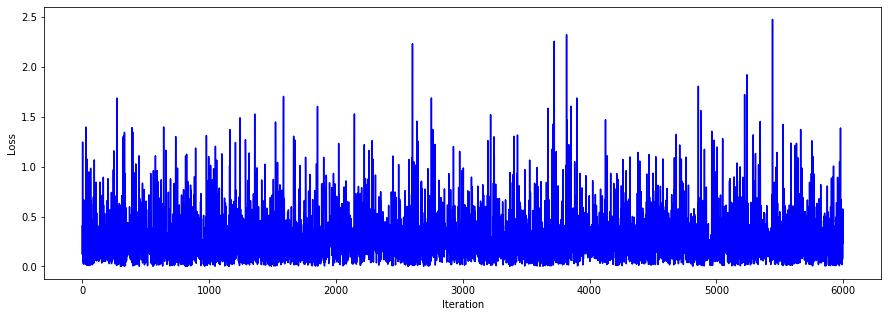

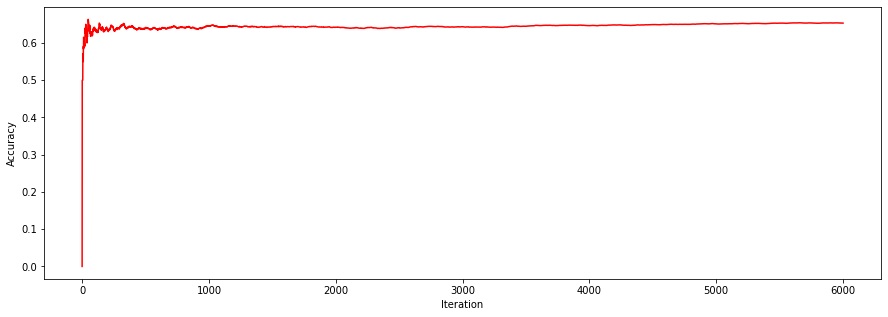

Loss: 0.2796381197533995, all_acc : 0.6531411431428105


6100it [1:01:57,  1.69it/s]

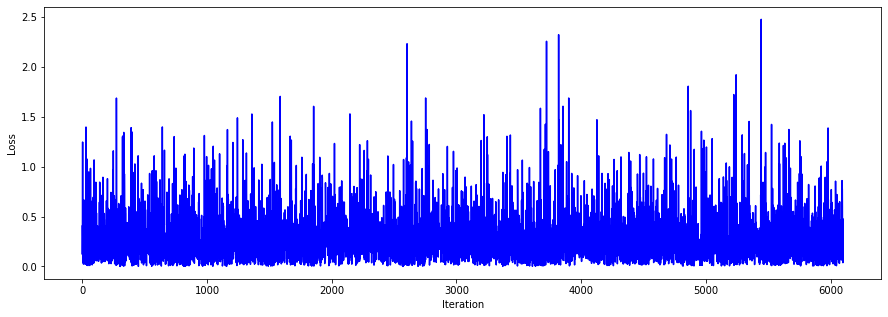

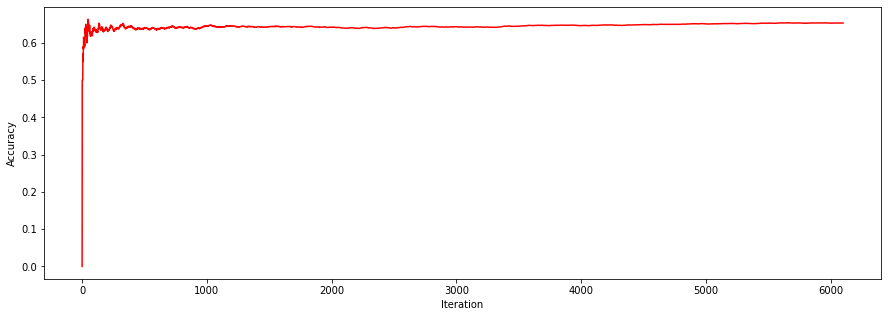

6101it [1:01:58,  1.32it/s]

Loss: 0.27973257817346564, all_acc : 0.653335518767416


6200it [1:02:58,  1.63it/s]

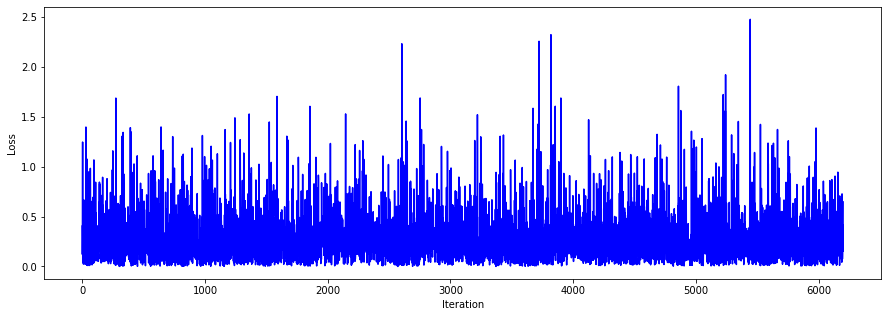

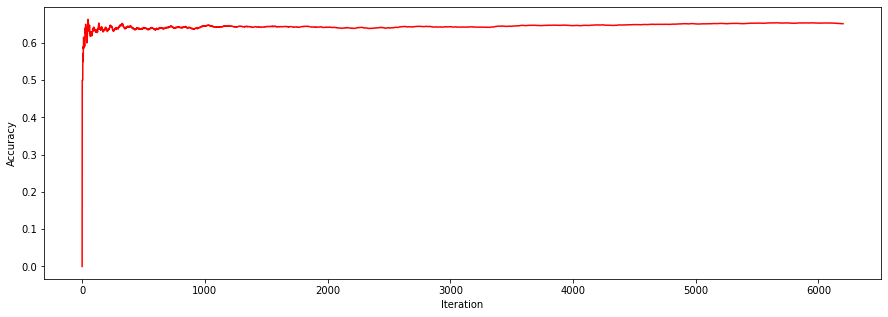

6201it [1:02:59,  1.31it/s]

Loss: 0.2803559351217949, all_acc : 0.6515884534752469


6300it [1:03:57,  1.72it/s]

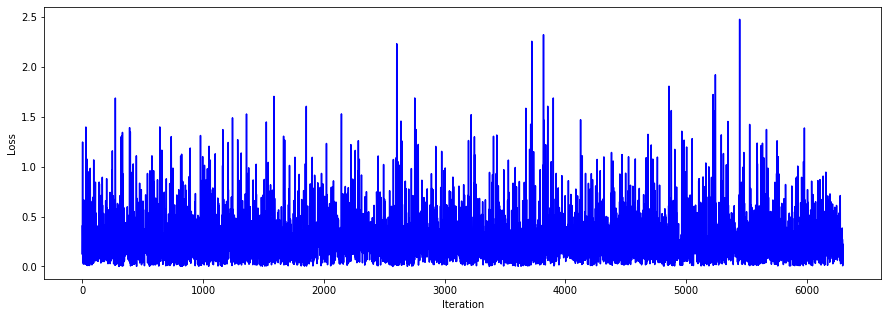

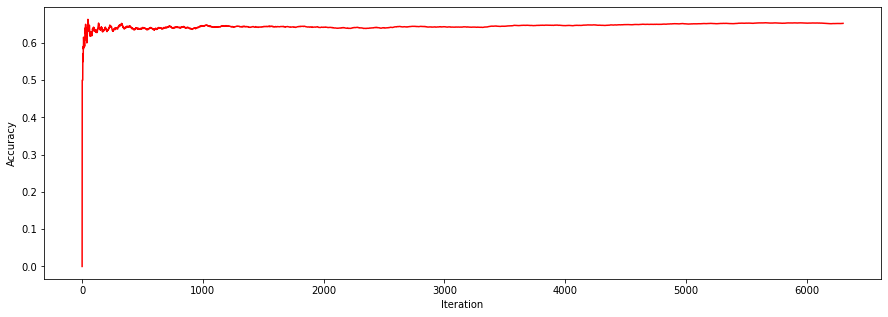

6301it [1:03:58,  1.37it/s]

Loss: 0.27976906800318285, all_acc : 0.6525154737343282


6400it [1:04:57,  1.61it/s]

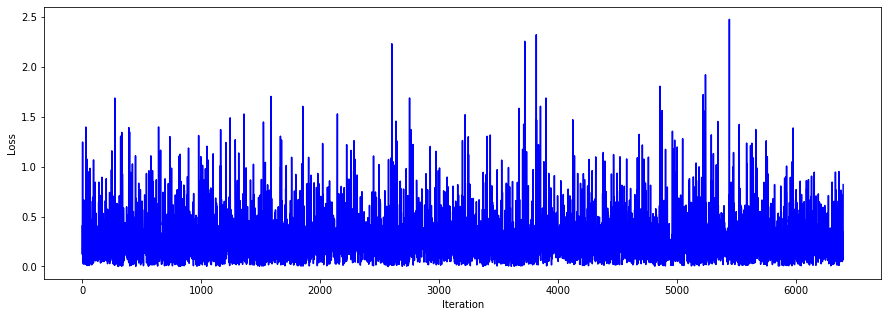

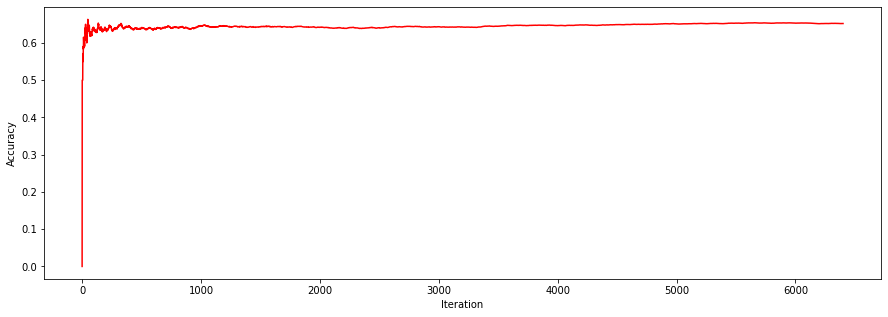

6401it [1:04:58,  1.37it/s]

Loss: 0.2796262955784601, all_acc : 0.6520856116231841


6500it [1:05:57,  1.71it/s]

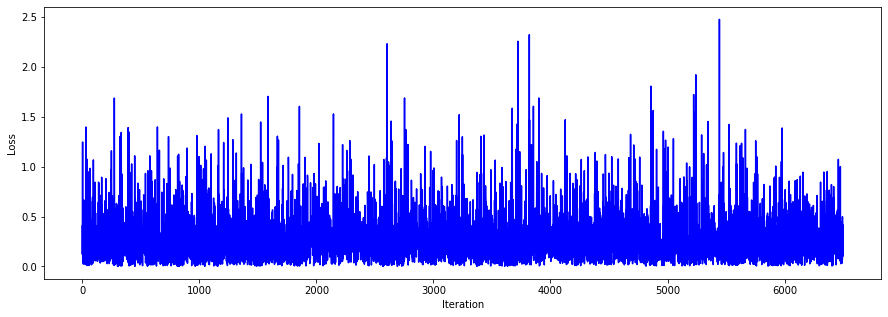

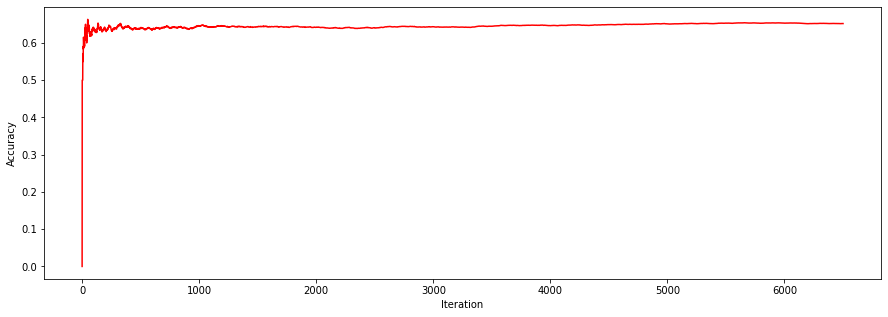

6501it [1:05:58,  1.47it/s]

Loss: 0.27966340886811414, all_acc : 0.6519766189816955


6600it [1:06:57,  1.82it/s]

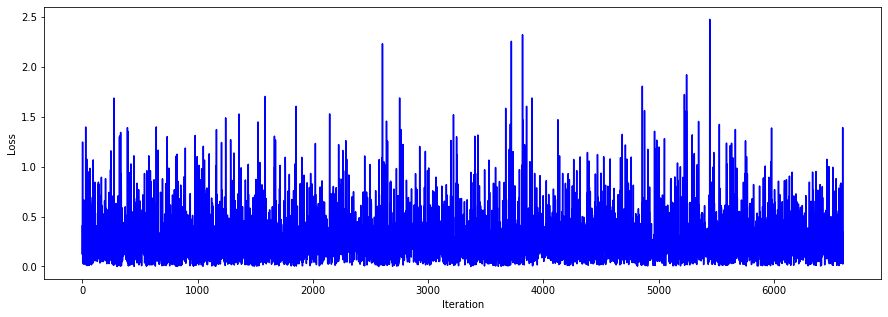

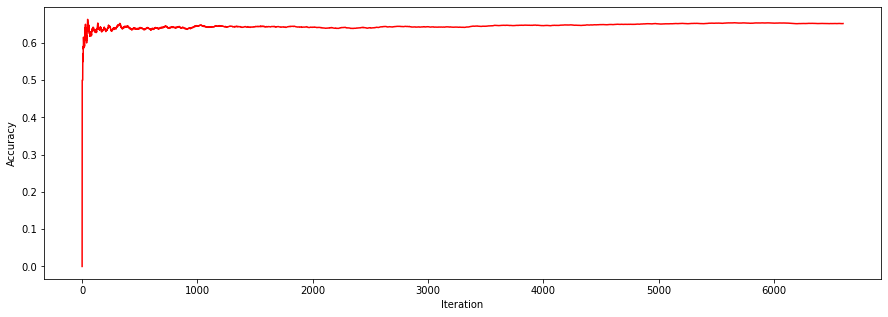

6601it [1:06:58,  1.50it/s]

Loss: 0.27980877258893705, all_acc : 0.6520224208453267


6700it [1:07:57,  1.75it/s]

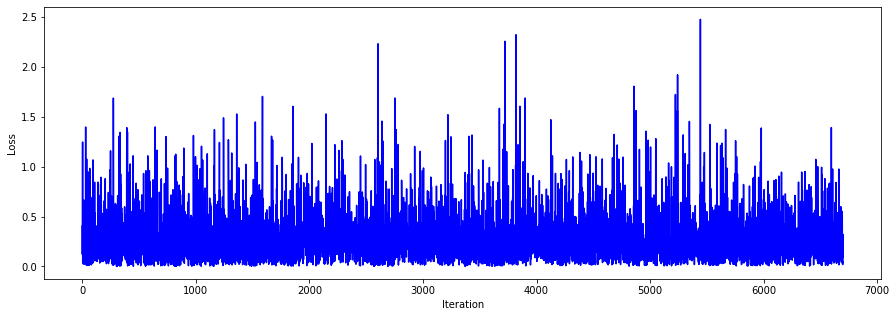

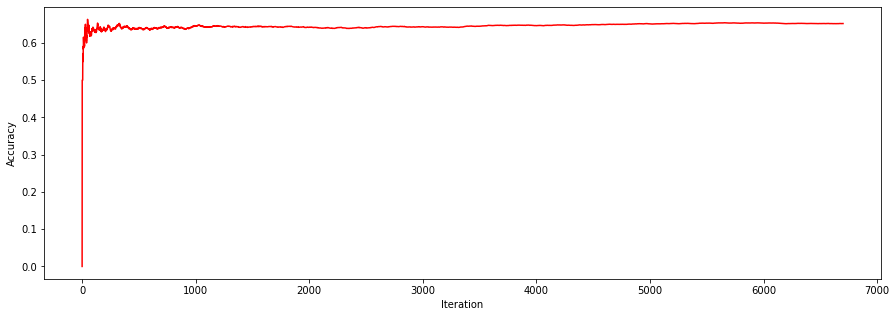

6701it [1:07:58,  1.36it/s]

Loss: 0.27957101737764856, all_acc : 0.6520668556931803


6762it [1:08:35,  1.76it/s]

In [ ]:
bert_re.train(setting['num_epochs'], setting['batch_size'], setting['lr'], setting['reg'])

In [ ]:
anth = RMTrainer(splited_data)

In [ ]:
#train reward model

anth.train(setting['num_epochs'], setting['batch_size'], setting['lr'], setting['reg'])

In [ ]:
#For test when reward error
train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-125M', bos_token='<|startoftext|>', eos_token='<|endoftext|>', padding_side="left")
tokenizer.pad_token = '<|endoftext|>'

base = GPTNeoModel.from_pretrained("EleutherAI/gpt-neo-125M").to(device)
rmm = GPTNeoRewardModel()
reward_layer = nn.Linear(768, 1).to(device)

for idx, data in enumerate(train_loader):
  if idx < 2:
    chosens, rejecteds = data
    print("Batch size : ", len(chosens))
    tokenized = tokenizer(chosens, return_tensors='pt', max_length=768, padding=True)
    input_ids, attention_mask=tokenized.input_ids.to(device), tokenized.attention_mask.to(device)

    print(len(input_ids), len(attention_mask))
    last_hidden_states = base(input_ids, attention_mask=attention_mask).last_hidden_state
    eos_hidden_states=last_hidden_states[:,-1,:]
    print(eos_hidden_states)
    rewards=reward_layer(eos_hidden_states)
    print(rewards)

## PPO Training

### PPO Dataset, Environment 준비

In [ ]:
max_length=300

In [ ]:
import re

#decompose HF dataset into episodic data (s,a,s,a,s,a,s,a,s_t) => consider end of dialogue as termination of an episode.
#treat phrases starting with * as Assistant's dialogue.
#used for on-policy training
class TrajectoryDataset(torch.utils.data.Dataset):
  def __init__(self, hf_dset):
    super(TrajectoryDataset, self).__init__()
    self.hf_dset=hf_dset
    self.trajectories=self.decompose_dset(self.hf_dset)
  
  def get_ep_steps_from_dialogue(self, text):
    text=text.replace("Humans:","Human:")
    text=text.replace("human:","Human:")
    text=text.replace("humans:","Human:")
    result = [x.strip('\n\n').strip() for x in re.split('Human:|Assistant:', text)[1:]]
    human_list = []
    assistant_list = []

    human_part = ""
    assistant_part = ""

    episodes = []
    for n in range(int(len(result)/2)):
      state = human_part + assistant_part + "Human: " + result[2*n]
      action = result[2*n+1]
      human_part = state + '\n\n'
      assistant_part = "Assistant: " + action + '\n\n'
      ep = {
          'state':state,
          'action':action
      }
      episodes.append(ep)
    
    return episodes

  def decompose_dset(self, hf_dset):
    trajectories=[]
    for hfd in hf_dset:
      chosen=hfd['chosen']
      trajectory=self.get_ep_steps_from_dialogue(chosen)
      trajectories.append(trajectory)
    return trajectories
  
  def __len__(self):
    return len(self.trajectories)
  
  def __getitem__(self, idx):
    text = self.trajectories[idx]
    text=text[0]['state']+"\n\nAssistant:"
    # inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=500, padding="max_length") #pad => special token X

    return text
    # return inputs['input_ids'][0]

In [ ]:
class PPOEnv():
  def __init__(self):
    super().__init__()
    self.dataset = TrajectoryDataset(train_dataset)
    self.dataloader = torch.utils.data.DataLoader(self.dataset, batch_size=1, shuffle=True)
    self.done = False
    self.did = [] # used states
    self.current_state = ""
    self.random_idx=0
    self.current_step=0

  # action is response
  def reset(self):
    get = True
    self.random_idx = 0
    self.current_step=0
    while get:
      self.random_idx=np.random.randint(low=0, high=len(self.dataset))
      if self.random_idx not in self.did:
        self.did.append(self.random_idx)
        get = False
    self.current_state = self.dataset[self.random_idx][0]['state']+"\n\nAssistant:"
    self.current_state = next(iter(self.dataloader))[0]['state'][0]+"\n\nAssistant:"
    return self.current_state

In [ ]:
num_episodes = 5000
actor_lr = 0.005 # sft model
critic_lr = 0.005  # reward model

Memory = namedtuple('Memory', [
    'sequences', 'rewards', 'action_log_probs', 'values', 'advantages', 'new_attention_mask'
])

#### InstructGPT 논문에 최대한 가깝게 구현

In [ ]:
class ExperienceDataset(torch.utils.data.Dataset):
  def __init__(self, data: List[torch.Tensor]):
    super().__init__()
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return tuple(self.data[index])

def create_dataloader(memories, batch_size, shuffle = True, **kwargs):
    ds = ExperienceDataset(memories)
    return torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=shuffle, **kwargs)

In [ ]:
class GPTNeoActors(nn.Module):
  def __init__(self):
    super(GPTNeoActors, self).__init__()
    #goal: generate response(action)

    #sft model
    #self.sft_model= GPTNeoForCausalLM.from_pretrained("EleutherAI/gpt-neo-125M").to(device)
    self.sft_model=GPT2LMHeadModel.from_pretrained('gpt2').to(device)
    #self.sft_model.load_state_dict(torch.load(sft_model_path))
    
    #policy to train
    self.model = model
    self.tokenizer = tokenizer
    self.tokenizer.pad_token = tokenizer.eos_token
  
  def get_sequence_probs(self, logits, sequences):
    batch_size, seq_length, vocab_size=logits.size()
    #sequences in size of (batch_size, seq_length) => (batch_size, seq_length, 1)
    probs=logits.softmax(dim=-1)
    result = torch.gather(probs, dim=-1, index=sequences.unsqueeze(-1))
    # Use the sum function to add up the log probabilities for each time step of the sequence
    seq_probs = result.sum(dim=-1)
    return seq_probs
  
  def get_sft_action_prob(self, input_length, batch_sequences, batch_attention_mask):
    #just input the whole sequence to lm model and it will output logits => simple prob. calculation.
    batch_size, seq_length=batch_sequences.size()
    seq_index=torch.arange(0, seq_length, 1).long().to(device)
    #create new attention mask
    new_attention_mask=torch.ones(batch_size, seq_length).to(device)
    new_attention_mask[:,:input_length]=batch_attention_mask

    #obtain sft logits
    out=self.sft_model(batch_sequences, attention_mask=new_attention_mask)
    seq_probs=self.get_sequence_probs(out.logits, batch_sequences)
    action_probs=seq_probs[:,input_length:]
    return action_probs
        
  def forward(self, batch_states, max_gen_length=200):
    # sample(generate) an action(response) based on the actor model
    tokenized = self.tokenizer(batch_states, return_tensors='pt', padding=True)
    batch_input_ids, batch_attention_mask = tokenized.input_ids.to(device), tokenized.attention_mask.to(device)
    input_length=batch_input_ids.size(1)
    generated = self.model.generate(batch_input_ids, attention_mask=batch_attention_mask, do_sample=True, max_length=max_gen_length, output_scores=True, return_dict_in_generate=True, pad_token_id=50256)
    # 답변 생성
    batch_sequences = generated.sequences #actions contains prompt => can be processed directly with reward model.
    batch_responses = batch_sequences[:,input_length:]

    response_logits = torch.stack(generated.scores, dim=0).permute(1,0,2) # 1, len(scores), vocab_size
    action_log_probs = torch.log(self.get_sequence_probs(response_logits, batch_responses)) # scores, sequences

    sft_action_log_probs=torch.log(self.get_sft_action_prob(input_length, batch_sequences, batch_attention_mask))
    batch_log_prob_ratio_list=action_log_probs-sft_action_log_probs
    batch_log_prob_ratio=torch.sum(batch_log_prob_ratio_list, dim=-1)

    return batch_sequences, batch_log_prob_ratio

In [ ]:
actor=GPTNeoActors()

In [ ]:
class InstructPPOs():
  def __init__(self, action_lr=0.001, critic_lr=0.001, epsilon=0.1, beta=0.01, gamma=0.95, epoch=1):
    # super.__init__(InstructPPO, self)
    self.critic = reward_model.to(device)
    self.reward_model=reward_model.to(device)
    # self.actor = GPTNeoActor()
    self.actor = actor
    self.beta = beta
    self.gamma = gamma
    self.epsilon = epsilon
    self.actor_reg = 0.5
    self.critic_reg = 0.5
    self.critic_lr = critic_lr
    self.action_lr = action_lr
    self.epochs=epoch
    self.env = PPOEnv()
    self.value_head=nn.Linear(768,1).to(device)

  def step(self, text):
    reward, eos = self.reward_model(text)
    critic, eos = self.critic(text)
    value = self.value_head(eos)
    return reward, value

  def train(self, update_timesteps=5, num_episodes=5):
    max_timesteps = 100
    time = 1
    memories = deque([])

    dataset = TrajectoryDataset(train_dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

    for episode in tqdm(range(num_episodes), desc="episodes"):
      for idx, batch_states in enumerate(dataloader):
        self.actor.train()
        self.critic.train()

        actor_optim=optim.AdamW(self.actor.parameters(), lr=actor_lr, weight_decay=self.actor_reg)
        critic_optim=optim.AdamW(self.critic.parameters(), lr=critic_lr, weight_decay=self.critic_reg)

        time += 1
        
        #get corresponding pretrain data
        # pretrain_data=next(iter(pretrain_loader))

        #get actions and next state
        batch_sequences, batch_log_prob_ratio=self.actor(batch_states, max_gen_length=max_length)
        batch_next_states=self.actor.tokenizer.batch_decode(batch_sequences, skip_special_tokens=False) # 질문과 답변이 텍스트로 나옴
        # print("한거 출력하자", batch_next_states[0])
        rewards, eos=self.reward_model(batch_next_states)
        rewards=rewards.detach()

        #compute loss for PPO and pretrain
        actor_loss=-torch.sum((rewards-self.beta*batch_log_prob_ratio))/len(batch_states)
        # actor_loss=actor_loss+gamma*self.get_pretrain_loss(pretrain_data)
        print("액터의 로스", actor_loss)

        #add pretrain loss
        actor_optim.zero_grad()
        actor_loss.backward()
        actor_optim.step()

        #train state value to match rewards
        loss_ftn=nn.MSELoss()
        for c_epoch in range(1, 3):
          state_values, eos=self.critic(batch_states)
          values=self.value_head(eos)
          critic_loss=loss_ftn(values, rewards) # 두개 차이?

          critic_optim.zero_grad()
          critic_loss.backward()
          critic_optim.step()

        if time % update_timesteps == 0:
          # self.learn(memories) # 쌓은 메모리를 바탕으로 학습
          # memories.clear()     # 이후 메모리 초기화 (원래 해야하나?)
          self.test()

  def test(self):
    dummy_questions=[
        "Human:Who are you?\n\nAssistant:",
        "Human:What do you like the most?\n\nAssistant:",
        "Human:I'm so hungry\n\nAssistant:"
    ]

    for idx, q in enumerate(dummy_questions):
      response, _ = self.actor([q])
      response_text = self.actor.tokenizer.batch_decode(response, skip_special_tokens=False)
      print(response_text)
    return

In [ ]:
ppo=InstructPPOs()

In [ ]:
ppo.train()

episodes:   0%|          | 0/5 [00:00<?, ?it/s]Input length of input_ids is 482, but `max_length` is set to 300. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


1 


2 


3 


4 


한거 출력하자 <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftex

episodes:   0%|          | 0/5 [00:11<?, ?it/s]

1 


2 




KeyboardInterrupt: ignored

#### 기존 PPO 방식대로 최대한 구현(다른 오픈 코드들 참고하여)

In [ ]:
class GPTNeoActor(nn.Module):
  def __init__(self):
    super(GPTNeoActor, self).__init__()
    self.sft_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
    self.tokenizer = GPT2Tokenizer.from_pretrained('EleutherAI/gpt-neo-125M', bos_token='<|startoftext|>', eos_token='<|endoftext|>', padding_side='left')
    self.tokenizer.pad_token='<|endoftext|>'
    self.model=model

  def get_sequence_probs(self, logits, responses):
    sftm_probs = logits.softmax(dim=-1)
    # gather를 이용해서 sft_probs에서 원하는 index의 값만 뽑아온다.
    result = torch.gather(sftm_probs, dim=-1, index=rearrange(responses, "... -> ... 1"))
    # Use the sum function to add up the log probabilities for each time step of the sequence
    seq_probs = result.sum(dim=-1)
    return seq_probs

  def get_new_log_probs(self, sequences, new_attention_masks):
    print("겟 뉴로그 안 까지는 온다.", sequences.shape, "쉐입 투", new_attention_masks.shape)
    out=self.model(sequences, attention_mask=new_attention_masks)
    seq_probs=self.get_sequence_probs(out.logits, sequences)
    log_seq_probs=torch.log(seq_probs)
    print("리턴을 잘한다")
    return log_seq_probs

  def get_sft_sequence_probs(self, input_length, sequences):
    seq_length = len(sequences)
    # seq_index=torch.arange(0, seq_length, 1).long()
    new_attention_mask=torch.ones(1, seq_length).to(device)

    #obtain sft logits
    out=self.sft_model(sequences, attention_mask=new_attention_mask)
    seq_probs=self.get_sequence_probs(out.logits, sequences)
    sft_action_probs=seq_probs[input_length:]
    # 질문 답변 전부를 넣으면 뭐가 나오지?
    # 입력된 = 직접 파인튜닝한 model이 만든 sequence(질문+답변)의 각 토큰에 해당하는 logits가 나온다.
    # sft_model이 계산했을 때 앞까지의 토큰을 보고 현재 토큰이 나올 확률 값들(logits기 때문에 지금은 확률 x)
    return sft_action_probs

  # actor는 state를 받아서 액션을 뱉는다.
  @torch.no_grad()
  def forward(self, prompt):
    self.sft_model.eval()

    tokenized = self.tokenizer(prompt, return_tensors="pt", max_length=max_length, padding=True).to(device)
    batch_input_ids, batch_attention_mask = tokenized['input_ids'].to(device), tokenized['attention_mask'].to(device)

    generated = self.model.generate(
        batch_input_ids,
        do_sample=True,
        attention_mask=batch_attention_mask,
        max_length=max_length,
        output_scores=True,
        return_dict_in_generate=True,
    )

    input_tokens_length = len(batch_input_ids[0])
    sequences, scores = generated.sequences, generated.scores # 여기서 sequences는 말그대로 prompt+action

    batch_new_attentions_mask=[]
    for i in range(batch_input_ids.shape[0]):
      new_attention_mask=torch.ones(sequences.shape[1]).to(device) # sequence 길이 만큼만 1 해준 것
      new_attention_mask[:len(sequences[i])] = 0
      batch_new_attentions_mask.append(new_attention_mask)
    batch_new_attentions_mask=torch.stack(batch_new_attentions_mask, dim=0)

    prompt_mask = torch.arange(len(sequences), device=device) < input_tokens_length # prompt까지만 1, 나머진 0
    action_mask = ~prompt_mask

    # responses = rearrange(sequences, "... -> 1 ...")
    responses = sequences[:, :-input_tokens_length]
    response_logits = torch.stack(scores, dim=0).permute(1, 0, 2)

    print("점검 ", responses.shape, "쉐입", response_logits.shape)
    print("중간 점검 ", sequences.shape, len(scores))
    
    # get action probabilities of RL
    action_log_probs = torch.log(self.get_sequence_probs(response_logits, responses)) # scores, sequences

    print("액션 로그 프롭스", action_log_probs.shape)

    # 점검  torch.Size([0, 137]) 쉐입 torch.Size([4, 111, 50257])
    # 중간 점검  torch.Size([4, 137]) 111
    # 액션 로그 프롭스 torch.Size([0, 137])
    # 지나옴 22 torch.Size([0, 137])

    action_sft_log_probs = torch.log(self.get_sft_sequence_probs(input_tokens_length, sequences))

    # log_prob_ratio_list = action_log_probs - action_sft_log_probs
    # log_prob_ratio=torch.sum(log_prob_ratio_list, dim=-1)
    return sequences, action_log_probs, action_sft_log_probs, batch_new_attentions_mask # 어짜피 리워드는 prompt + response로 결정되니까 sequence 전체 반환.

In [ ]:
actor=GPTNeoActor()
env=PPOEnv()

In [ ]:
class InstructPPO():
  def __init__(self, action_lr=0.001, critic_lr=0.001, epsilon=0.1, beta=0.01, gamma=0.95, epoch=1):
    # super.__init__(InstructPPO, self)
    self.critic = reward_model.to(device)
    self.reward_model=reward_model.to(device)
    # self.actor = GPTNeoActor()
    self.actor = actor
    self.beta = beta
    self.gamma = gamma
    self.epsilon = epsilon
    self.actor_reg = 0.5
    self.critic_reg = 0.5
    self.critic_lr = critic_lr
    self.action_lr = action_lr
    self.epochs=epoch
    # self.env = PPOEnv()
    self.env = env
    self.value_head=nn.Linear(768,1).to(device)

  def step(self, text):
    reward, eos = self.reward_model(text)
    critic, eos = self.critic(text)
    value = self.value_head(eos)
    return reward, value

  def train(self, update_timesteps=5, num_episodes=5000):
    max_timesteps = 100
    time = 1
    memories = deque([])

    dataset = TrajectoryDataset(train_dataset)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

    for episode in tqdm(range(num_episodes), desc="episodes"):
      for idx, batch_states in enumerate(dataloader):
        self.actor.eval()
        self.reward_model.eval()
        self.critic.eval()
        time += 1

        batch_sequences, action_log_probs, action_sft_log_probs, new_attention_mask = self.actor(batch_states)

        # get Human:, Assistant:  texts for make reward
        batch_sequences_text = self.actor.tokenizer.batch_decode(batch_sequences, skip_special_tokens=True)
        print("지나옴 22", action_log_probs.shape)

        # get reward as given by supervised trained reward model
        self.reward_model.eval()
        rewards, values = self.step(batch_sequences_text)
        rewards = rewards.detach()

        # sequences = torch.cat([sequences, torch.ones(120-len(sequences)).to(device)], dim=-1)
        sequences = batch_sequences

        advantages = rewards - values

        memories.append(Memory(
            sequences, rewards, action_log_probs, values, advantages, new_attention_mask
        ))

        # 여기까지가 그냥 PPO
        # gamma * pretrain loss 해주면 PPO-ptx

        if time % update_timesteps == 0:
          self.learn(memories) # 쌓은 메모리를 바탕으로 학습
          memories.clear()     # 이후 메모리 초기화 (원래 해야하나?)
          self.test()

  def learn(self, memories:List[Memory], batch_size=1, beta=0.2):
    print("learning...")
    self.actor.train()
    self.critic.train()

    actor_optim=optim.AdamW(self.actor.parameters(), lr=actor_lr, weight_decay=self.actor_reg)
    critic_optim=optim.AdamW(self.critic.parameters(), lr=critic_lr, weight_decay=self.critic_reg)
    dl = create_dataloader(memories, batch_size=batch_size)

    for _ in range(self.epochs):
      # sequence = state + action
      actor_loss=0
      critic_loss=0
      for (sequences, rewards, old_action_log_probs, old_values, advantages, new_attention_masks) in dl:
        print("start learning.")
        # train actor
        # sequence를 가지고 현재의 actor로 계산한 logits랑 해서 ratio 계산해야한다.
        new_action_log_probs = self.actor.get_new_log_probs(sequences, new_attention_masks)
        new_action_log_probs = new_action_log_probs[:, :, -old_action_log_probs.shape[2]:]
        print("\njust in case\n", new_action_log_probs.shape, old_action_log_probs.shape)
        ratios=(new_action_log_probs - old_action_log_probs).exp()

        actor_loss=torch.sum((rewards-beta*ratios))/batch_size
        print("actor_loss : ", actor_loss.detach())

        actor_optim.zero_grad()
        actor_loss.backward()
        actor_optim.step()

        # train critic
        # 현재의 critic으로 new value를 계산한다.
        print("크리틱 계산 시작 ")
        new_v=[]
        for s in sequences.squeeze():
          print(s)
          critics, eos = self.critic(s)
          print("밸류해드 시작 ")
          new_values=self.value_head(eos)
          new_v.append(new_values)
        new_values=torch.stack(new_values, dim=0)

        # 리워드 모델이랑 new value랑 차이가 작아지도록 업데이트가 된다?
        print("거의 끝", torch.sum(rewards), rewards)
        critic_loss = nn.MSELoss(new_values, rewards)

        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()

      self.test()
    return

  def test(self):
    print("테스트 시작")

    dummy_questions=[
        "Who are you?",
        "What do you like the most?",
        "I'm so hungry"
    ]

    for idx, q in enumerate(dummy_questions):
      response = self.actor(q)
      response_text = self.actor.tokenizer.batch_decode(response, skip_special_tokens=True)
      print(response_text)
    return

In [ ]:
class PPO():
  def __init__(self, action_lr=0.001, critic_lr=0.001, epsilon=0.1, beta=0.01, gamma=0.95, epoch=1):
    super().__init__()
    self.critic = reward_model
    self.reward_model=reward_model
    self.actor = GPTNeoActor()
    self.beta = beta
    self.gamma = gamma
    self.epsilon = epsilon
    self.actor_reg = 0.5
    self.critic_reg = 0.5
    self.critic_lr = critic_lr
    self.action_lr = action_lr
    self.state = ""
    self.epochs=epoch
    self.env = PPOEnv()
    self.value_head=nn.Linear(768,1)

  def reset(self):
    self.critic = reward_model

  def step(self, sequence):
    reward, eos = self.reward_model(sequence)
    _, eos = self.critic(sequence)
    value = self.value_head(eos)
    print("스텝의 밸류 : ", value, reward)

    # last_hidden_states = outs.last_hidden_states
    # values=self.value_head(last_hidden_states).squeeze(-1)
    # value=values.mean()
    return reward, value
    
  def train(self, update_timesteps=5):
    max_timesteps = 100
    time = 0
    memories = deque([])

    for episode in tqdm(range(1, num_episodes+1), desc="episodes"):
      for timestep in range(max_timesteps):
        self.actor.eval()
        self.reward_model.eval()
        self.critic.eval()
        time += 1

        state = self.env.reset() # get prompts
        self.state = state # this is text "Human:~~\n\nAssistant:"

        sequences, action_log_probs, action_sft_log_probs, new_attention_mask = self.actor(state)

        # get Human:, Assistant:  texts for make reward
        sequences_text = self.actor.tokenizer.batch_decode(sequences, skip_special_tokens=True)[0]

        # get reward as given by supervised trained reward model
        self.reward_model.eval()
        reward, value = self.step(sequences_text)
        reward = reward.detach()

        sequences = torch.cat([sequences, torch.ones(120-len(sequences)).to(device)], dim=-1)

        advantages = reward - value

        memories.append(Memory(
            sequences, reward, action_log_probs, value, advantages, new_attention_mask
        ))

        # 여기까지가 그냥 PPO
        # gamma * pretrain loss 해주면 PPO-ptx

        if time % update_timesteps == 0:
          self.learn(memories) # 쌓은 메모리를 바탕으로 학습
          memories.clear()     # 이후 메모리 초기화 (원래 해야하나?)
  
  def learn(self, memories:List[Memory], batch_size=4):
    self.actor.train()
    self.critic.train()

    actor_optim=optim.AdamW(self.actor.parameters(), lr=actor_lr, weight_decay=self.actor_reg)
    critic_optim=optim.AdamW(self.critic.parameters(), lr=critic_lr, weight_decay=self.critic_reg)
    dl = create_dataloader(memories, batch_size=batch_size)

    for _ in range(self.epochs):
      # sequence = state + action
      actor_loss=0
      critic_loss=0
      for (sequences, rewards, old_action_log_probs, old_values, advantages, new_attention_masks) in dl:
        # train actor
        # sequence를 가지고 현재의 actor로 계산한 logits랑 해서 ratio 계산해야한다.
        new_action_log_probs = self.actor.get_new_log_probs(sequences, new_attention_masks) # 배치로 들어간다. (batch_size, )
        ratios=(new_action_log_probs-old_action_log_probs).exp()

        surr1 = ratios * advantages
        surr2 = ratios.clamp(1 - self.epsilon, 1 + self.epsilon) * advantages

        actor_loss = -torch.min(surr1, surr2) # - self.beta_s * entropies
        actor_loss = actor_loss.mean()

        actor_optim.zero_grad()
        actor_loss.backward()
        actor_optim.step()

        # train critic
        # 현재의 critic으로 new value를 계산한다.
        new_values = self.critic(sequences)
        clipped_values=old_values + (new_values - old_values).clamp(-self.epsilon, self.epsilon)

        # 리워드 모델이랑 new value랑 차이가 작아지도록 업데이트가 된다?
        surr1 = F.smooth_l1_loss(new_values.squeeze(), rewards.squeeze())
        surr2 = F.smooth_l1_loss(clipped_values.squeeze(), rewards.squeeze())

        critic_loss = torch.max(surr1, surr2)
        critic_loss = critic_loss.mean()

        critic_optim.zero_grad()
        critic_loss.backward()
        critic_optim.step()

In [ ]:
# calculate value loss and update value network separate from policy network

# 여기서 리워드는 sequences로 계산한거, 
# value_loss = clipped_value_loss(values, rewards, old_values, self.value_clip)
# value_loss = value_loss.mean()

# 리워드와 value는 뭐가 다를까..? value는 단순히 현재의 SFT model에서 마지막에 1 dimension한 값?
